# Gain Stability

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import colors
from matplotlib.colors import LogNorm
from matplotlib.ticker import AutoMinorLocator, ScalarFormatter, NullLocator, FixedLocator, MultipleLocator
from matplotlib import gridspec
from matplotlib.image import NonUniformImage
from matplotlib.patches import Rectangle
import math
%matplotlib inline
from scipy.optimize import curve_fit
import straxbra
from pymongo import MongoClient
from pymongo.son_manipulator import ObjectId
import os
import strax
import datetime
import time

In [2]:
__client = MongoClient(os.environ['MONGO_DAQ_URI'])
db = __client['xebra_daq']
experiment = 'xebra'
MAX_RUN_ID = 999999  # because reasons

In [3]:
def _GetRundoc(run_id):
    query = {'run_id' : min(int(run_id), MAX_RUN_ID), 'experiment' : experiment}
    doc = db['runs'].find_one(query)
    #if doc is None:
    #    raise ValueError('No run with id %d' % run_id)
    return doc  # returns None if no doc

def GetGainsEarlier(run_id):
    doc = _GetRundoc(run_id)
    if doc is None:
        return np.ones(8)
    run_start = ObjectId.from_datetime(doc['start'])
    try:
        earlier_doc = list(db['pmt_gains'].find({'_id' : {'$lte' : run_start}}).sort([('_id', -1)]).limit(1))[0]
    except IndexError:
        return np.ones(8)
    earlier_cal = int(str(earlier_doc['_id'])[:8], 16)
    return np.array([earlier_doc['adc_to_pe'][ch] for ch in range(len(earlier_doc['adc_to_pe']))])

def GetGainsLater(run_id):
    doc = _GetRundoc(run_id)
    if doc is None:
        return np.ones(8)
    run_start = ObjectId.from_datetime(doc['start'])
    try:
        earlier_doc = list(db['pmt_gains'].find({'_id' : {'$lte' : run_start}}).sort([('_id', -1)]).limit(1))[0]
    except IndexError:
        return np.ones(8)
    try:
        later_doc = list(db['pmt_gains'].find({'_id' : {'$gte' : run_start}}).sort([('_id', 1)]).limit(1))[0]
    except IndexError:
        return np.array(earlier_doc['adc_to_pe'])
    later_cal = int(str(later_doc['_id'])[:8], 16)
    return np.array([later_doc['adc_to_pe'][ch] for ch in range(len(earlier_doc['adc_to_pe']))])

def GetGainsInterploted(run_id):
    doc = _GetRundoc(run_id)
    if doc is None:
        return np.ones(8)
    run_start = ObjectId.from_datetime(doc['start'])
    try:
        earlier_doc = list(db['pmt_gains'].find({'_id' : {'$lte' : run_start}}).sort([('_id', -1)]).limit(1))[0]
    except IndexError:
        return np.ones(8)
    try:
        later_doc = list(db['pmt_gains'].find({'_id' : {'$gte' : run_start}}).sort([('_id', 1)]).limit(1))[0]
    except IndexError:
        return np.array(earlier_doc['adc_to_pe'])
    earlier_cal = int(str(earlier_doc['_id'])[:8], 16)
    later_cal = int(str(later_doc['_id'])[:8], 16)
    return np.array([np.interp(doc['start'].timestamp(),
                                [earlier_cal,later_cal],
                                [earlier_doc['adc_to_pe'][ch], later_doc['adc_to_pe'][ch]])
                        for ch in range(len(earlier_doc['adc_to_pe']))])

In [4]:
run = '00158'
filenameprefix = 'run_'+run

In [5]:
GetGainsEarlier(run)

array([0.0046202 , 0.00187813, 0.00129807, 0.00089172, 0.00146338,
       0.0051292 , 0.00261079, 0.00127369])

In [6]:
GetGainsLater(run)

array([0.00454839, 0.00192189, 0.00140142, 0.00091437, 0.00152282,
       0.00528823, 0.00253482, 0.00136719])

In [7]:
straxbra.utils.GetGains(run)

array([0.0046199 , 0.00187831, 0.00129849, 0.00089181, 0.00146362,
       0.00512985, 0.00261048, 0.00127407])

In [8]:
GetGainsInterploted(run)

array([0.0046199 , 0.00187831, 0.00129849, 0.00089181, 0.00146362,
       0.00512985, 0.00261048, 0.00127407])

In [9]:
run_id_list = np.array([])
gains_interpolated_list = np.full(8, np.nan)
gains_earlier_list = np.full(8, np.nan)
gains_later_list = np.full(8, np.nan)

for index, run_id in enumerate(np.arange(100, 251+1)):
    
    run_id_list = np.append(run_id_list, run_id)
    
    if len(str(run_id)) == 3:
        run_id_string = '00'+str(run_id)
    elif len(str(run_id)) == 2:
        run_id_string = '000'+str(run_id)
    elif len(str(run_id)) == 1:
        run_id_string = '0000'+str(run_id)
    else:
        print('Failed to set run_id_string')
        
    gains_interpolated_list = np.vstack((gains_interpolated_list, GetGainsInterploted(run_id)))
    gains_earlier_list = np.vstack((gains_earlier_list, GetGainsEarlier(run_id)))
    gains_later_list = np.vstack((gains_later_list, GetGainsLater(run_id)))
    
gains_interpolated_list = gains_interpolated_list[1:]
gains_earlier_list = gains_earlier_list[1:]
gains_later_list = gains_later_list[1:]

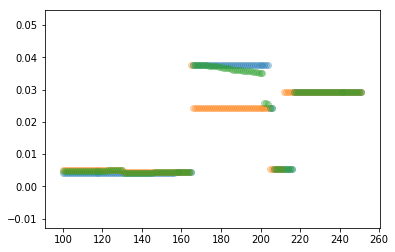

In [10]:
plt.scatter(run_id_list, gains_earlier_list[:,0], alpha = 0.3)
plt.scatter(run_id_list, gains_later_list[:,0], alpha = 0.3)
plt.scatter(run_id_list, gains_interpolated_list[:,0], alpha = 0.3)
plt.show()

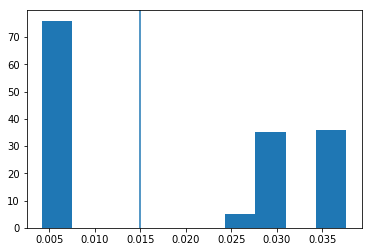

In [11]:
plt.hist(gains_interpolated_list[:,0])
plt.axvline(x = 0.015)
plt.show()

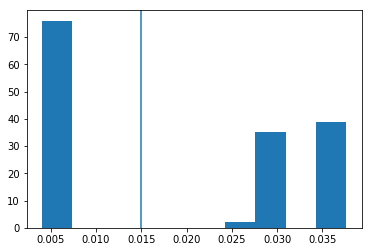

In [12]:
plt.hist(gains_earlier_list[:,0])
plt.axvline(x = 0.015)
plt.show()

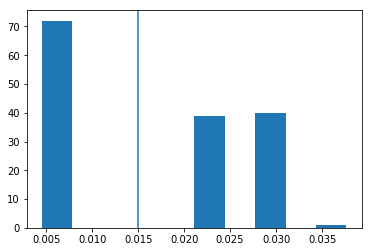

In [13]:
plt.hist(gains_later_list[:,0])
plt.axvline(x = 0.015)
plt.show()

In [14]:
## Rescale with additional amplification
amp_scale = (1-0.9*(gains_interpolated_list[:,0] > 0.015))
amp_scale_list = np.array([[am]*gains_interpolated_list.shape[1] for am in amp_scale])
gains_interpolated_list_ampcorrected = amp_scale_list*gains_interpolated_list

amp_scale = (1-0.9*(gains_earlier_list[:,0] > 0.015))
amp_scale_list = np.array([[am]*gains_earlier_list.shape[1] for am in amp_scale])
gains_earlier_list_ampcorrected = amp_scale_list*gains_earlier_list

amp_scale = (1-0.9*(gains_later_list[:,0] > 0.015))
amp_scale_list = np.array([[am]*gains_later_list.shape[1] for am in amp_scale])
gains_later_list_ampcorrected = amp_scale_list*gains_later_list

In [15]:
label_size = 30
mpl.rcParams['font.size']=label_size

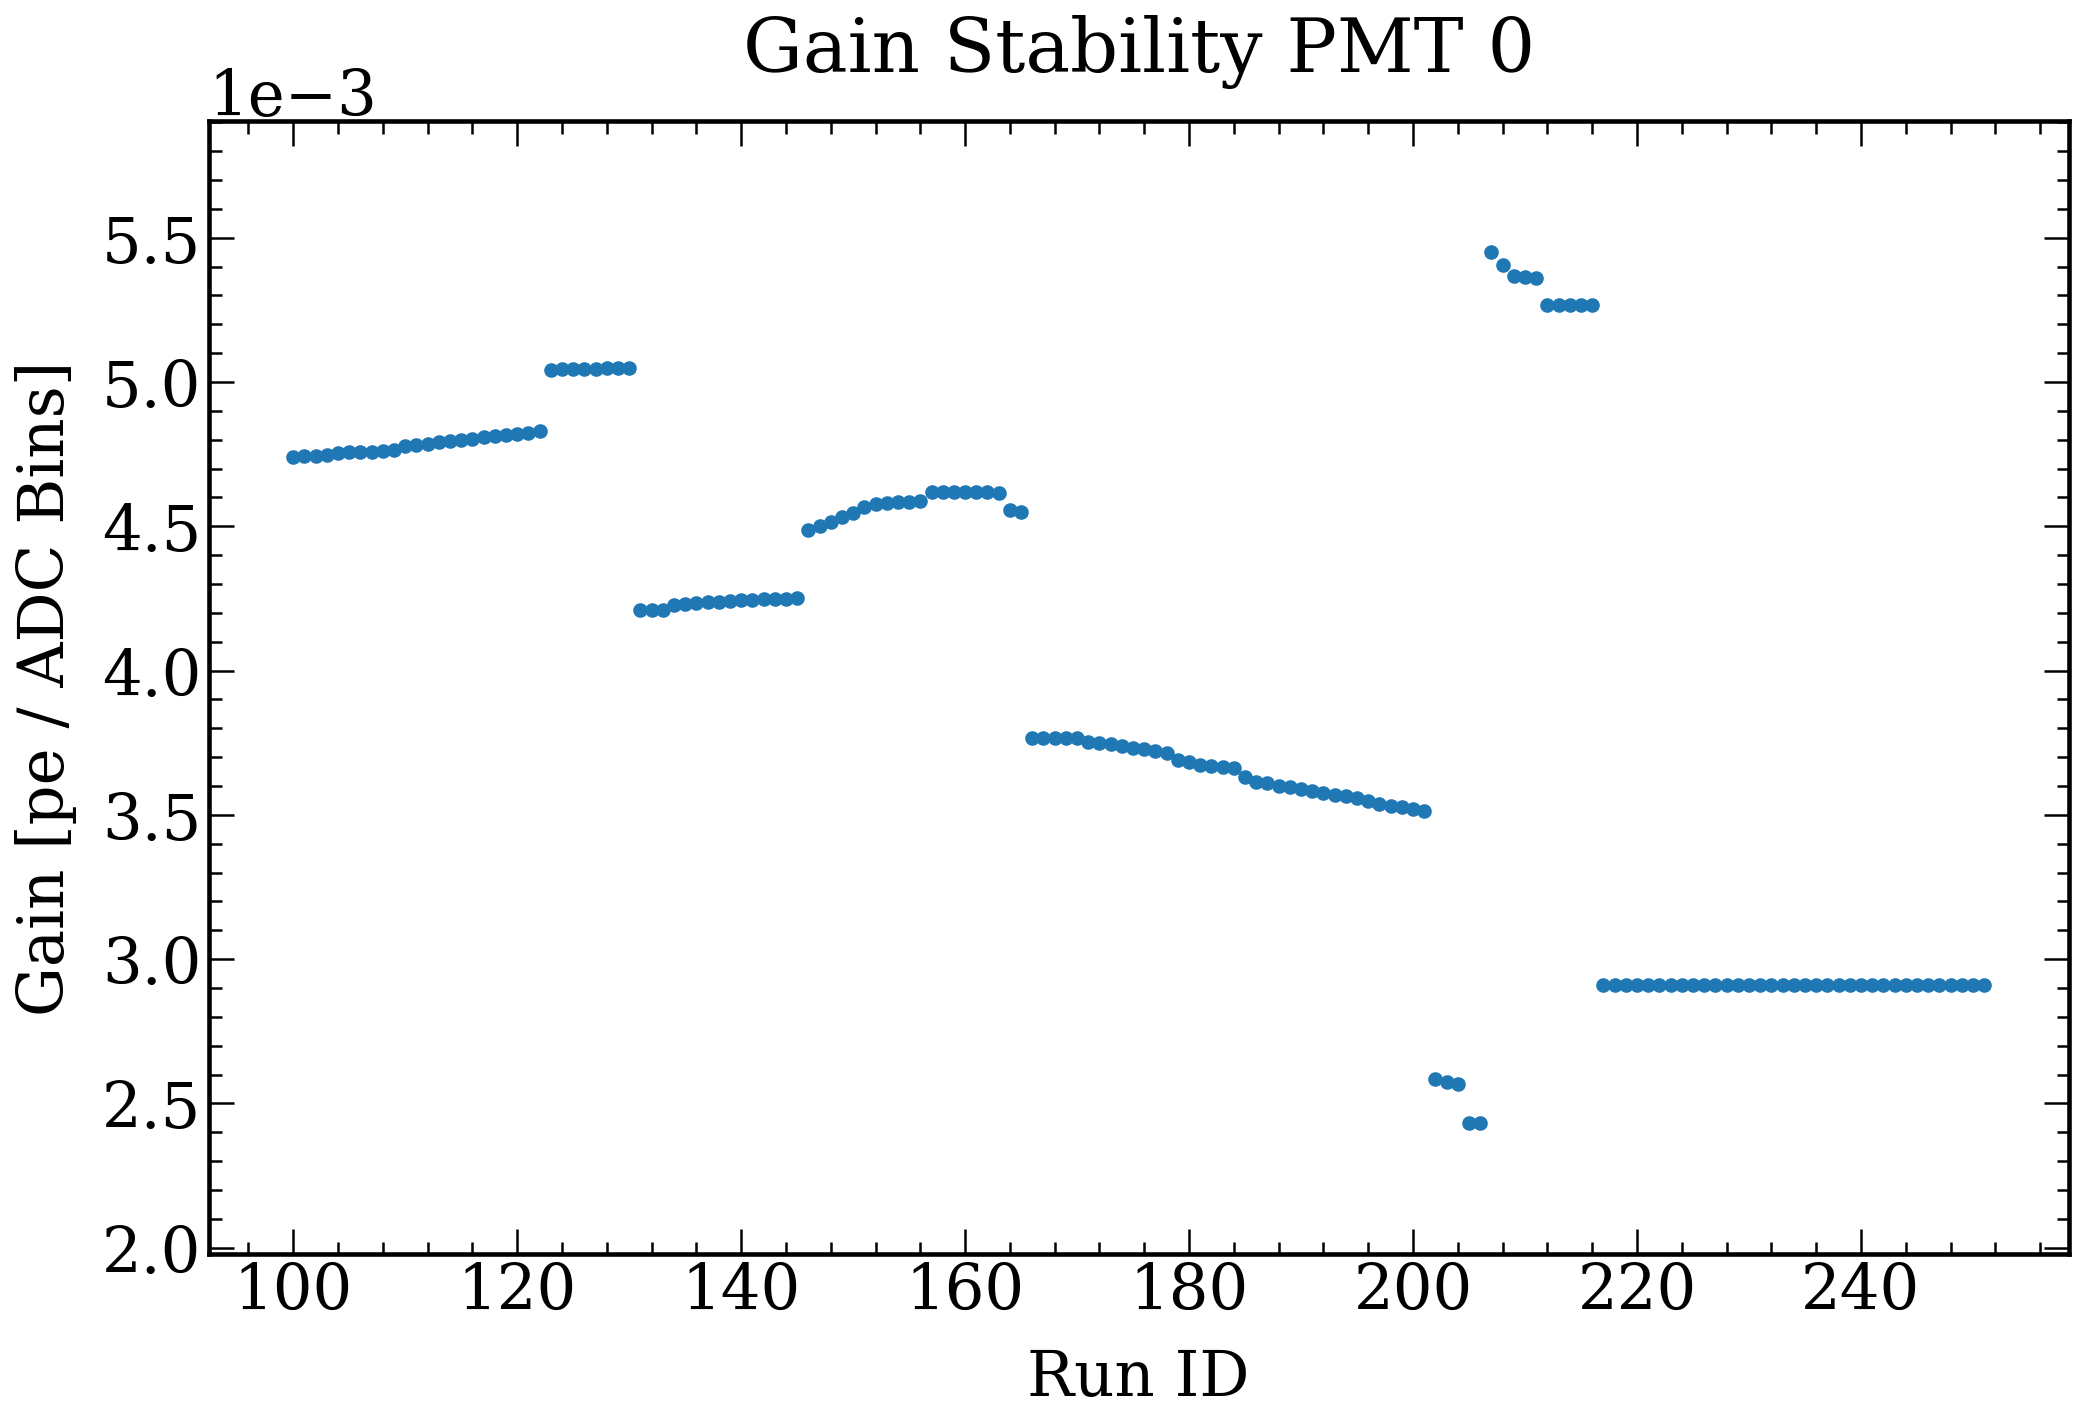

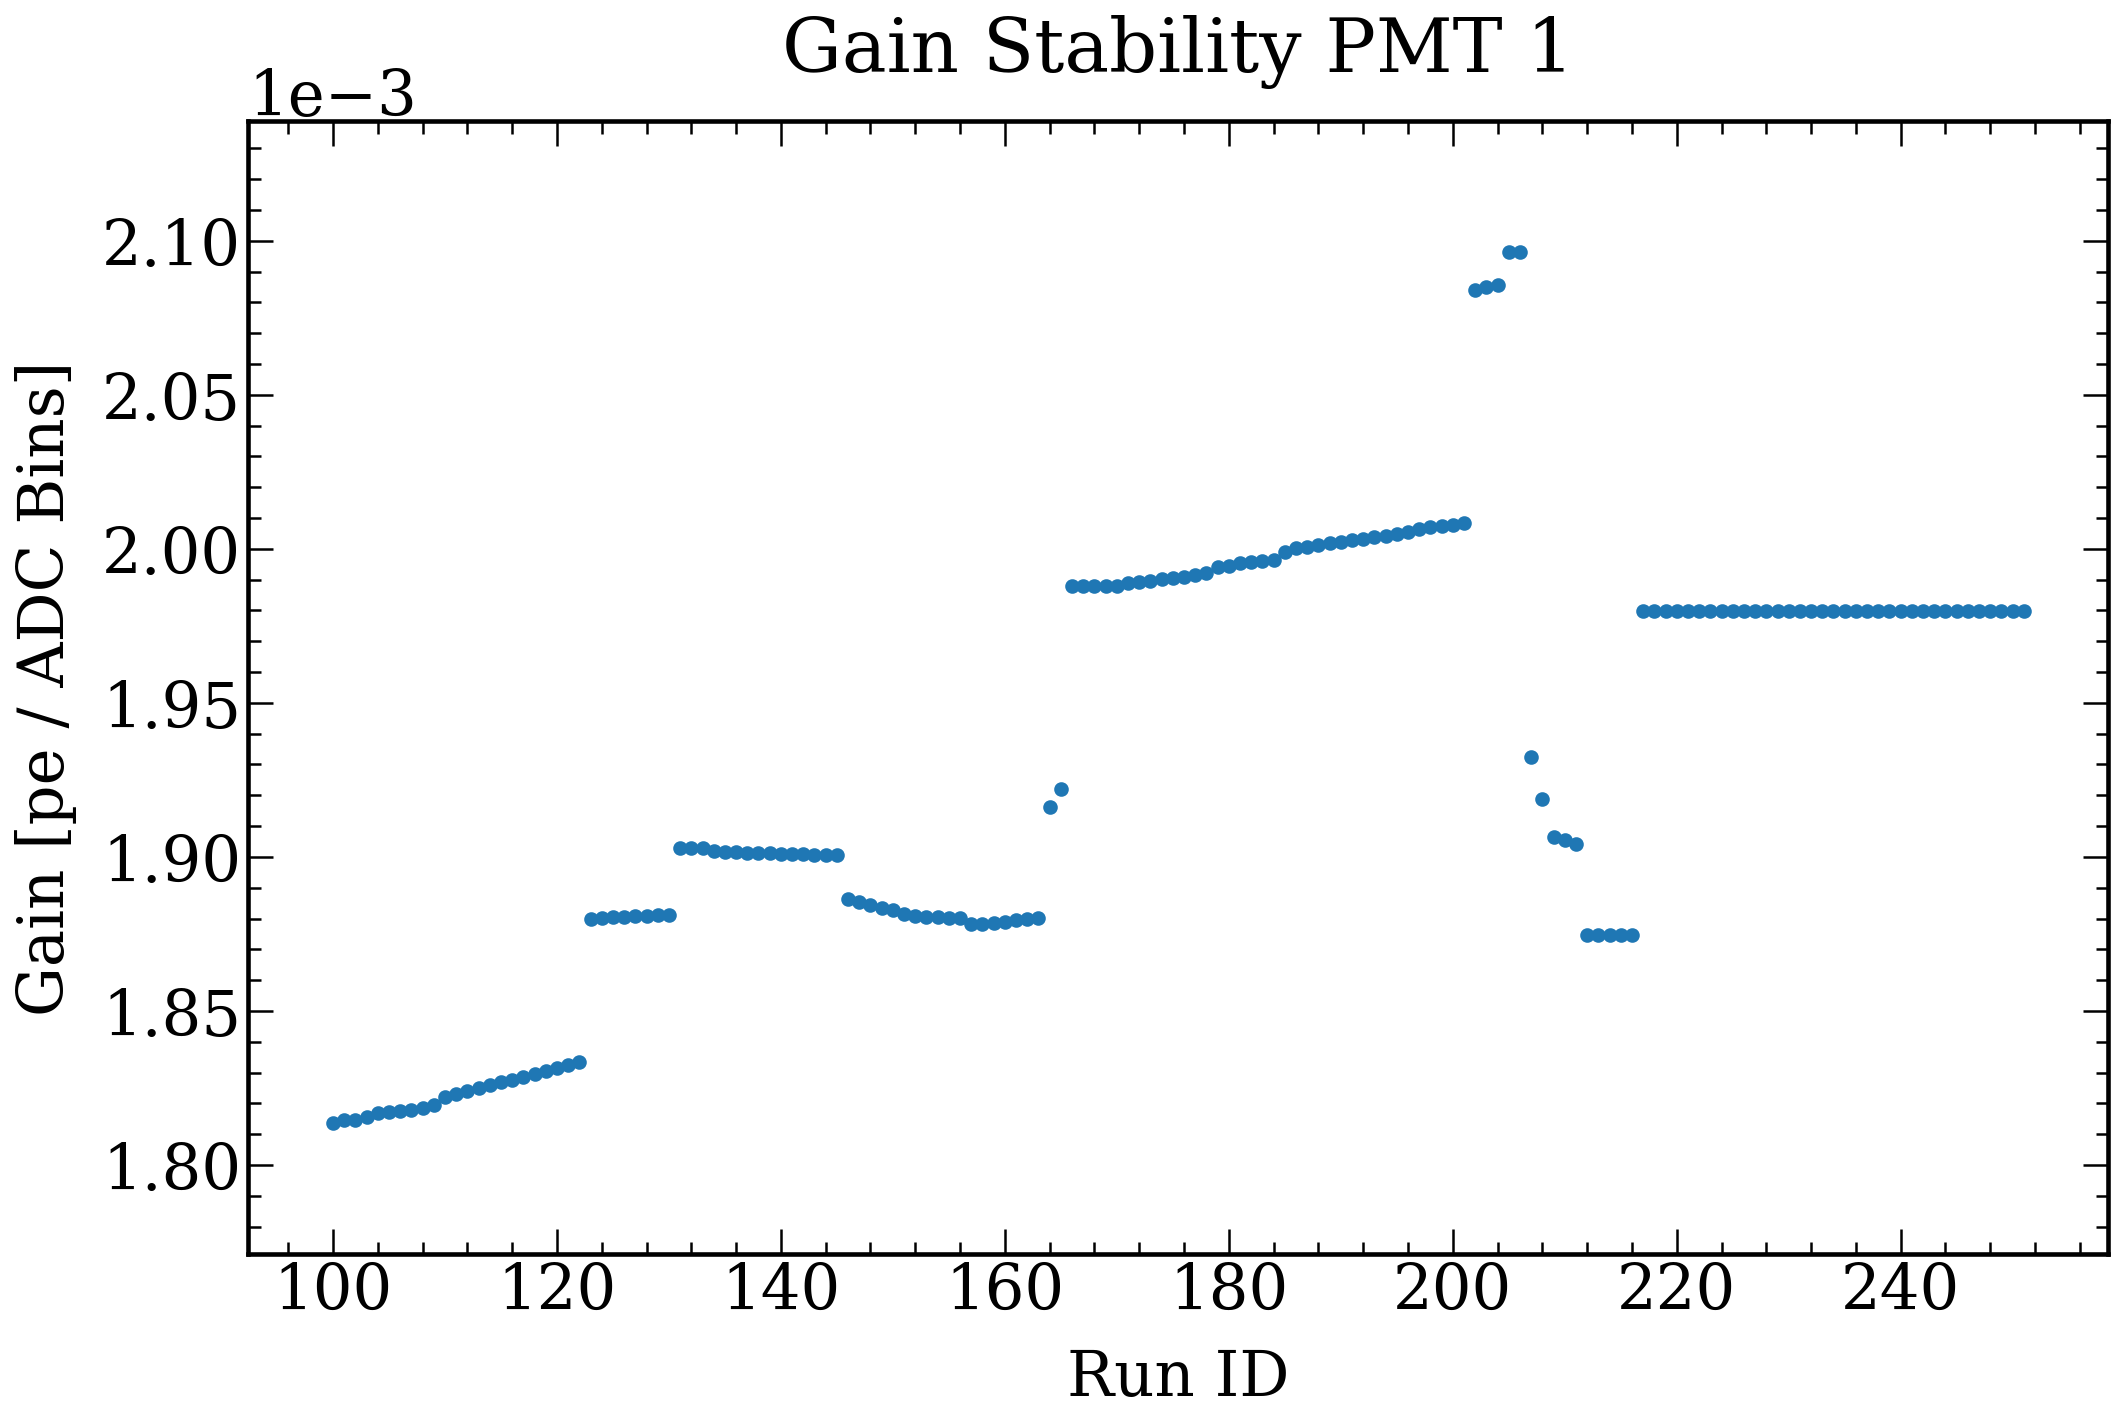

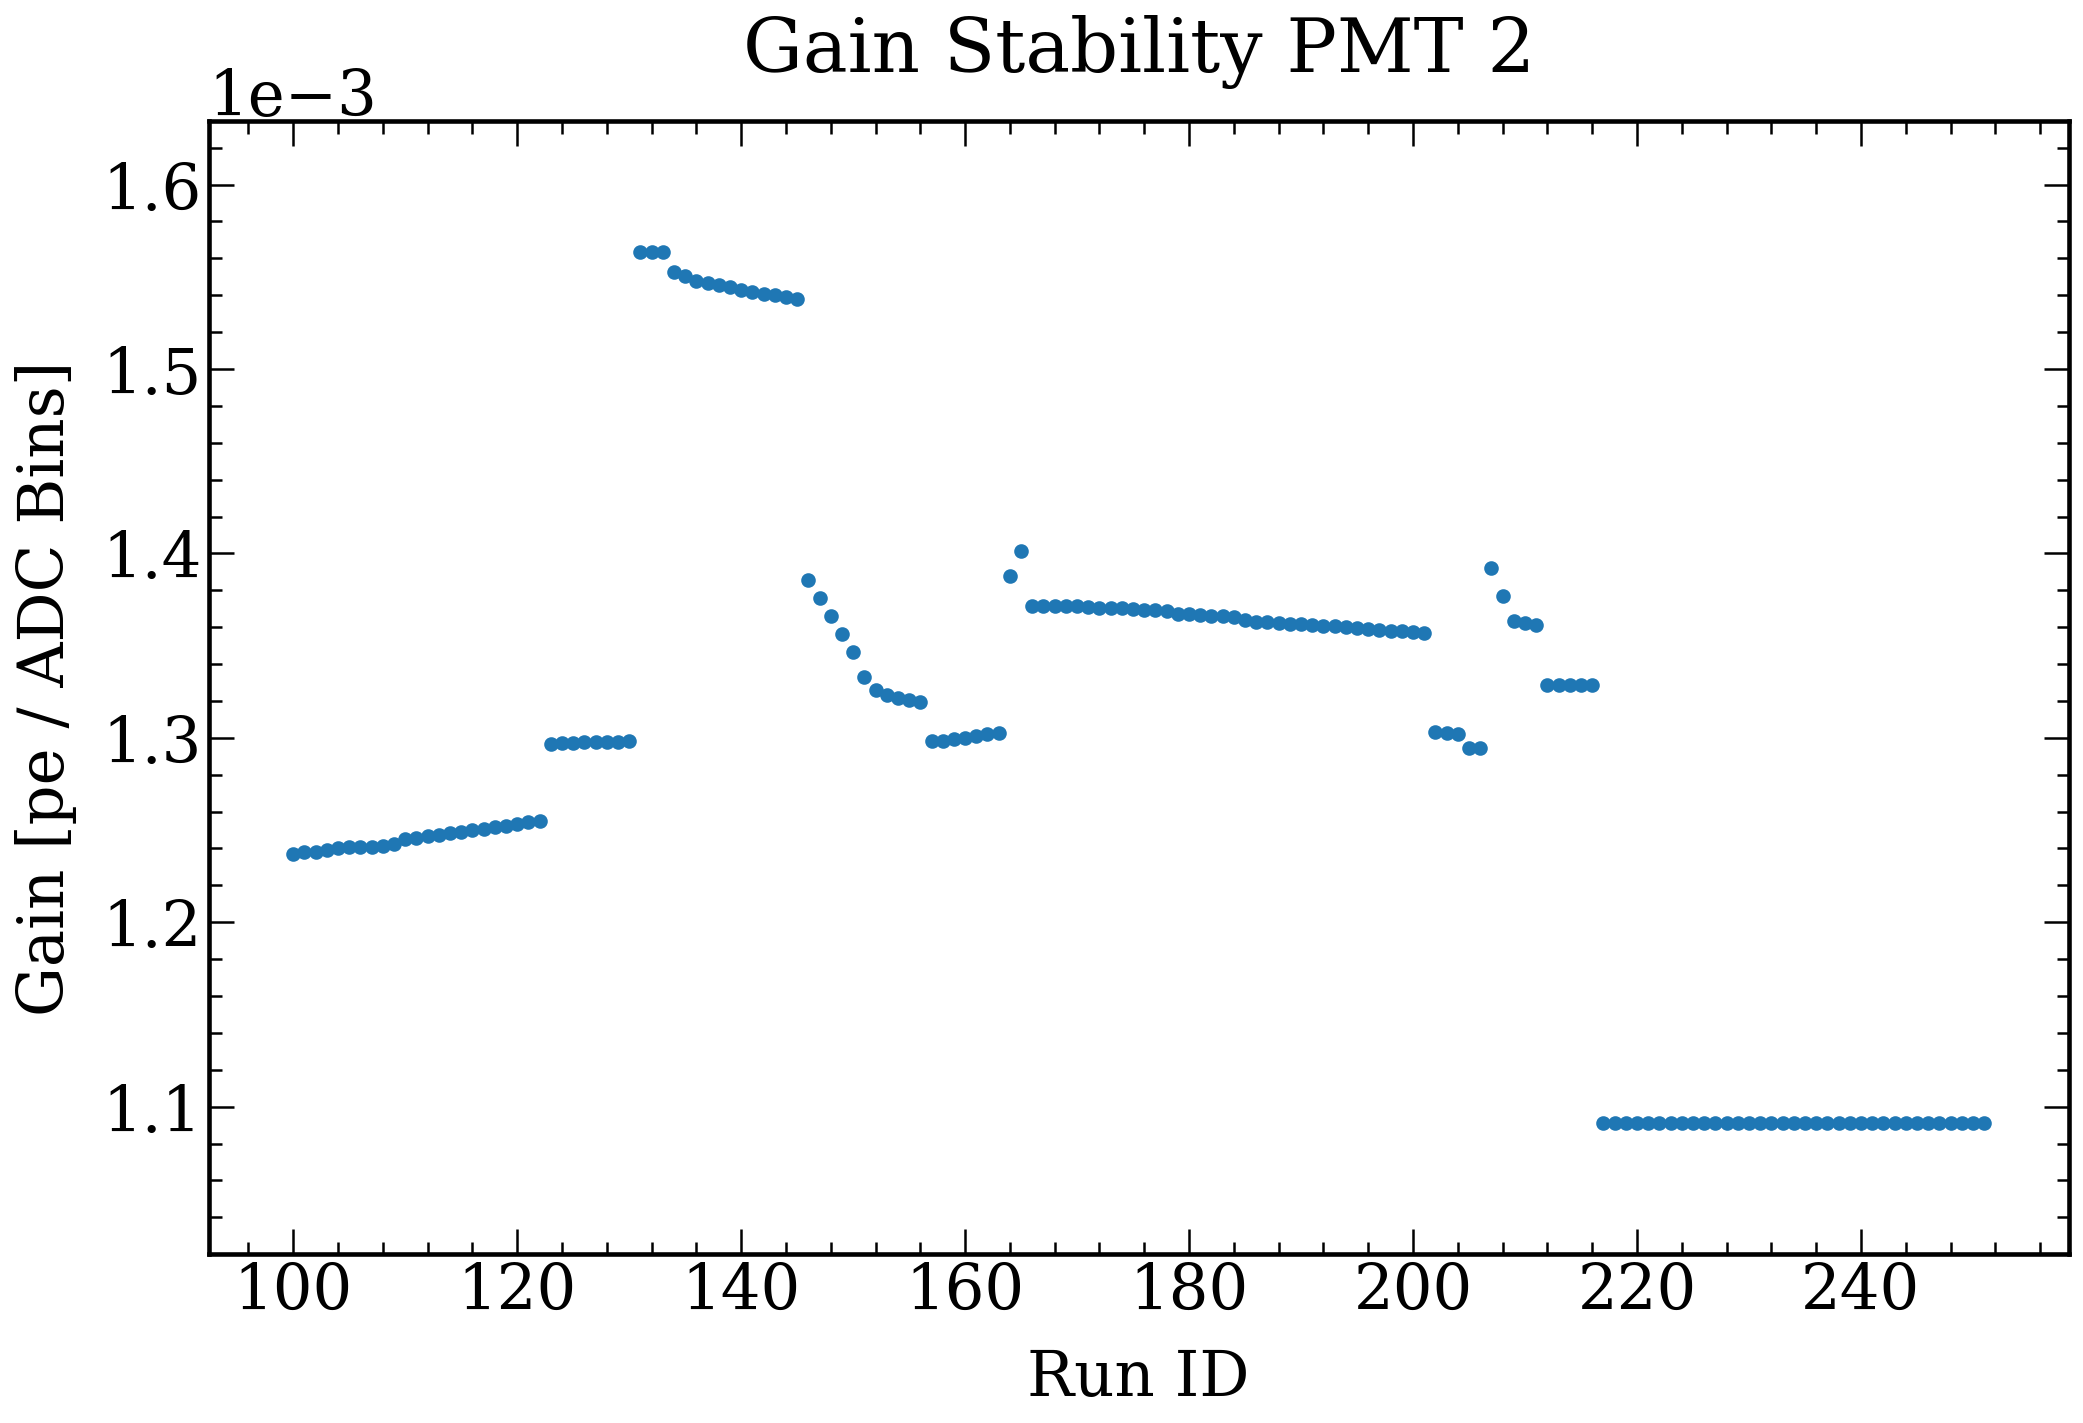

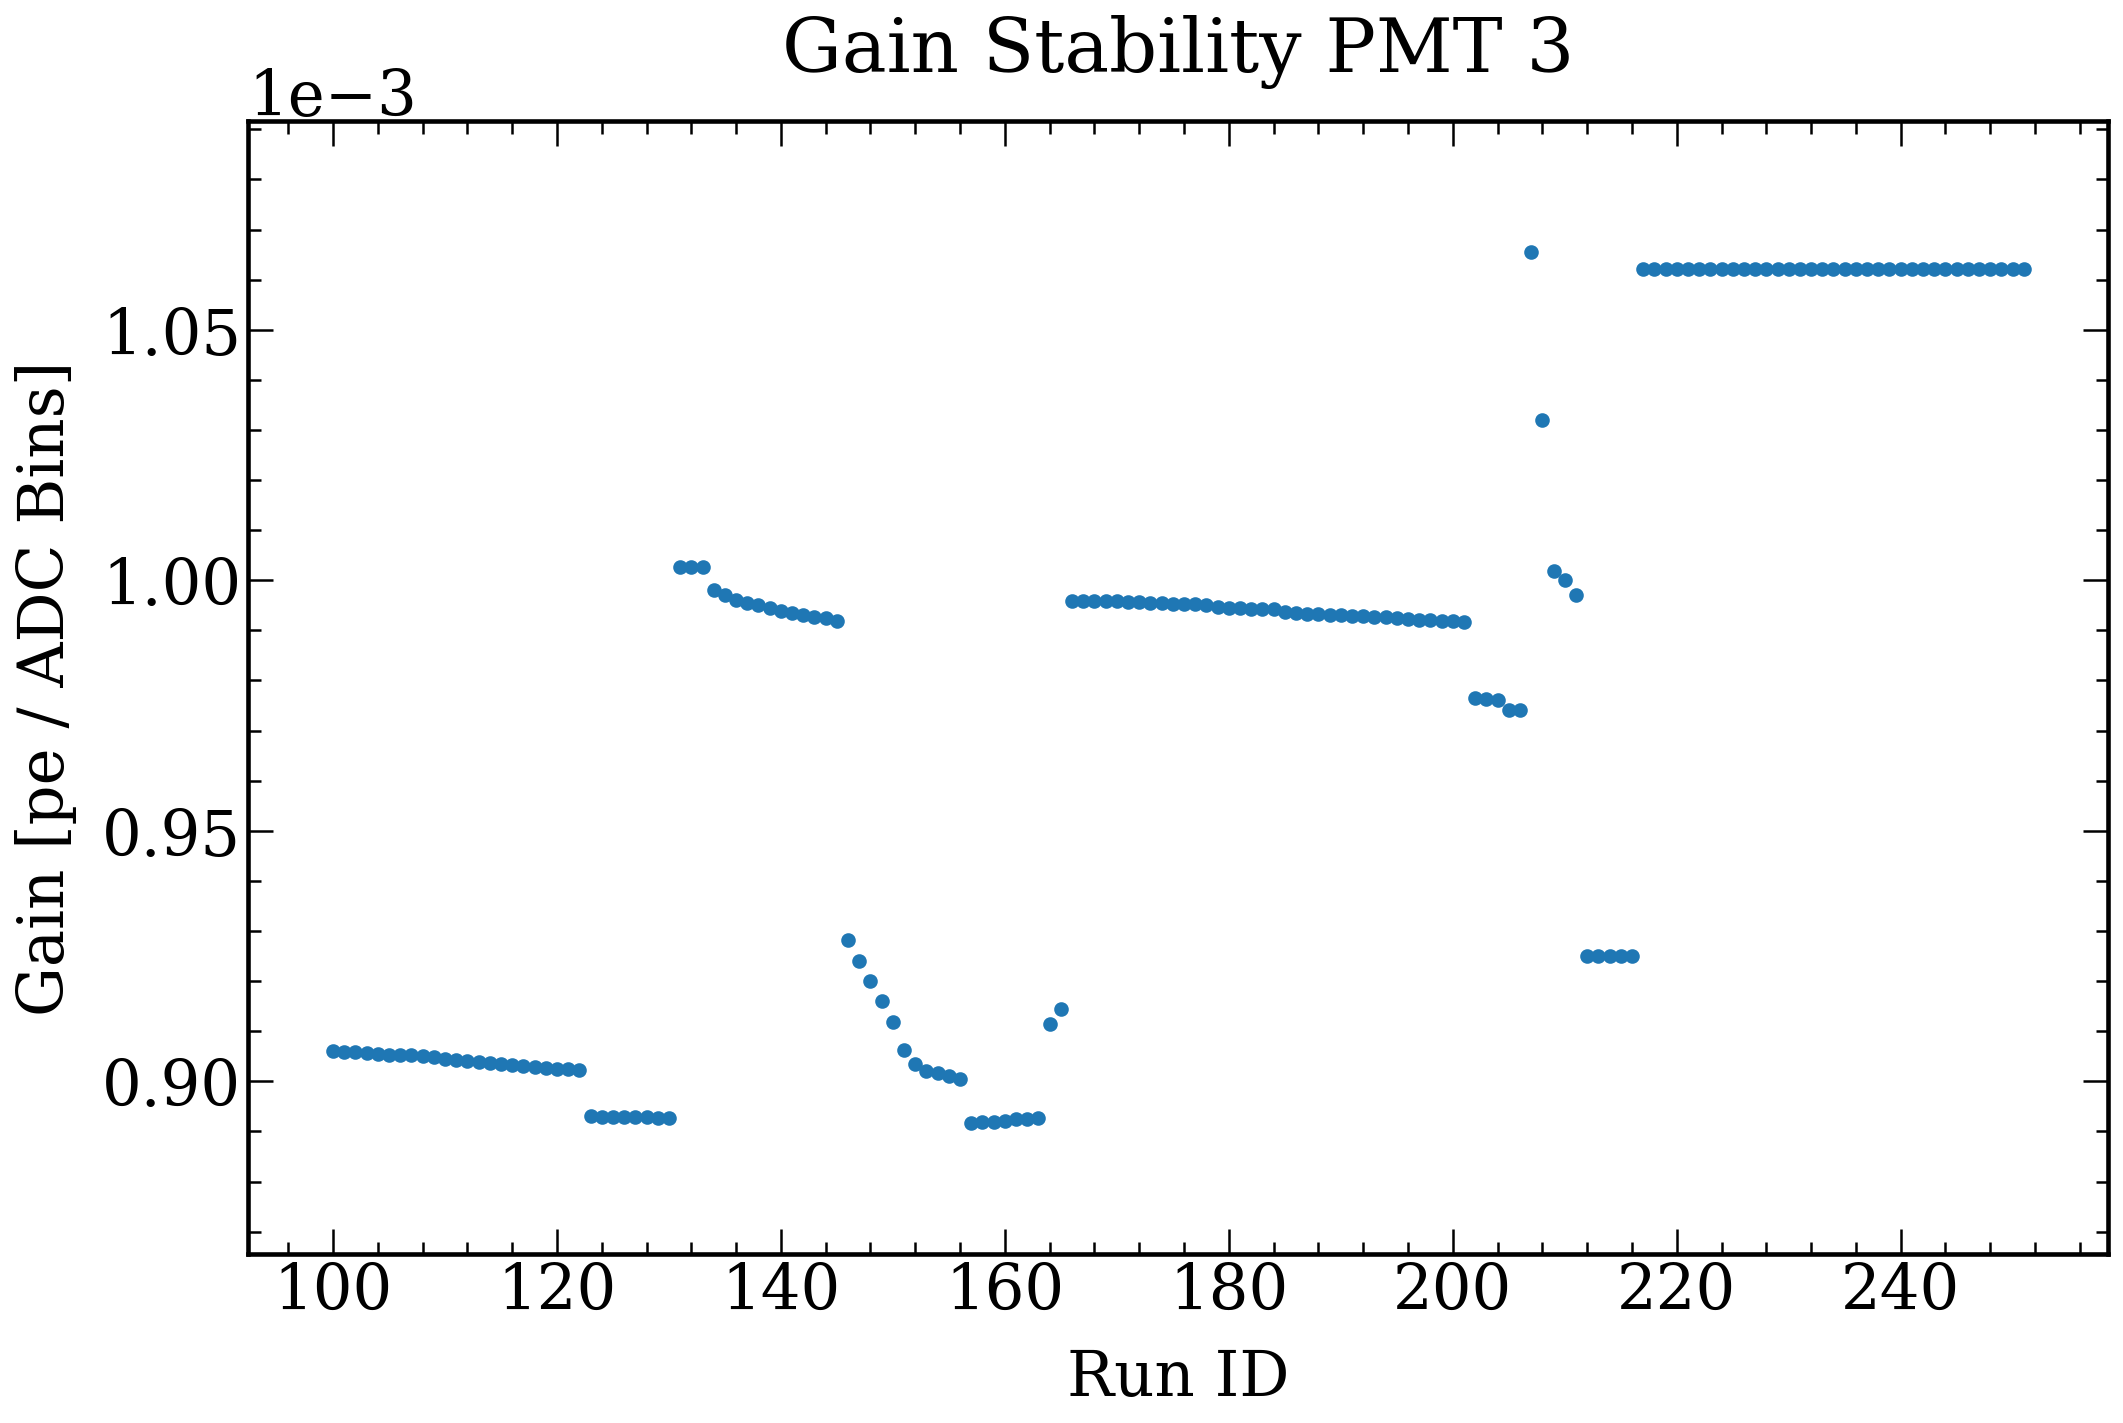

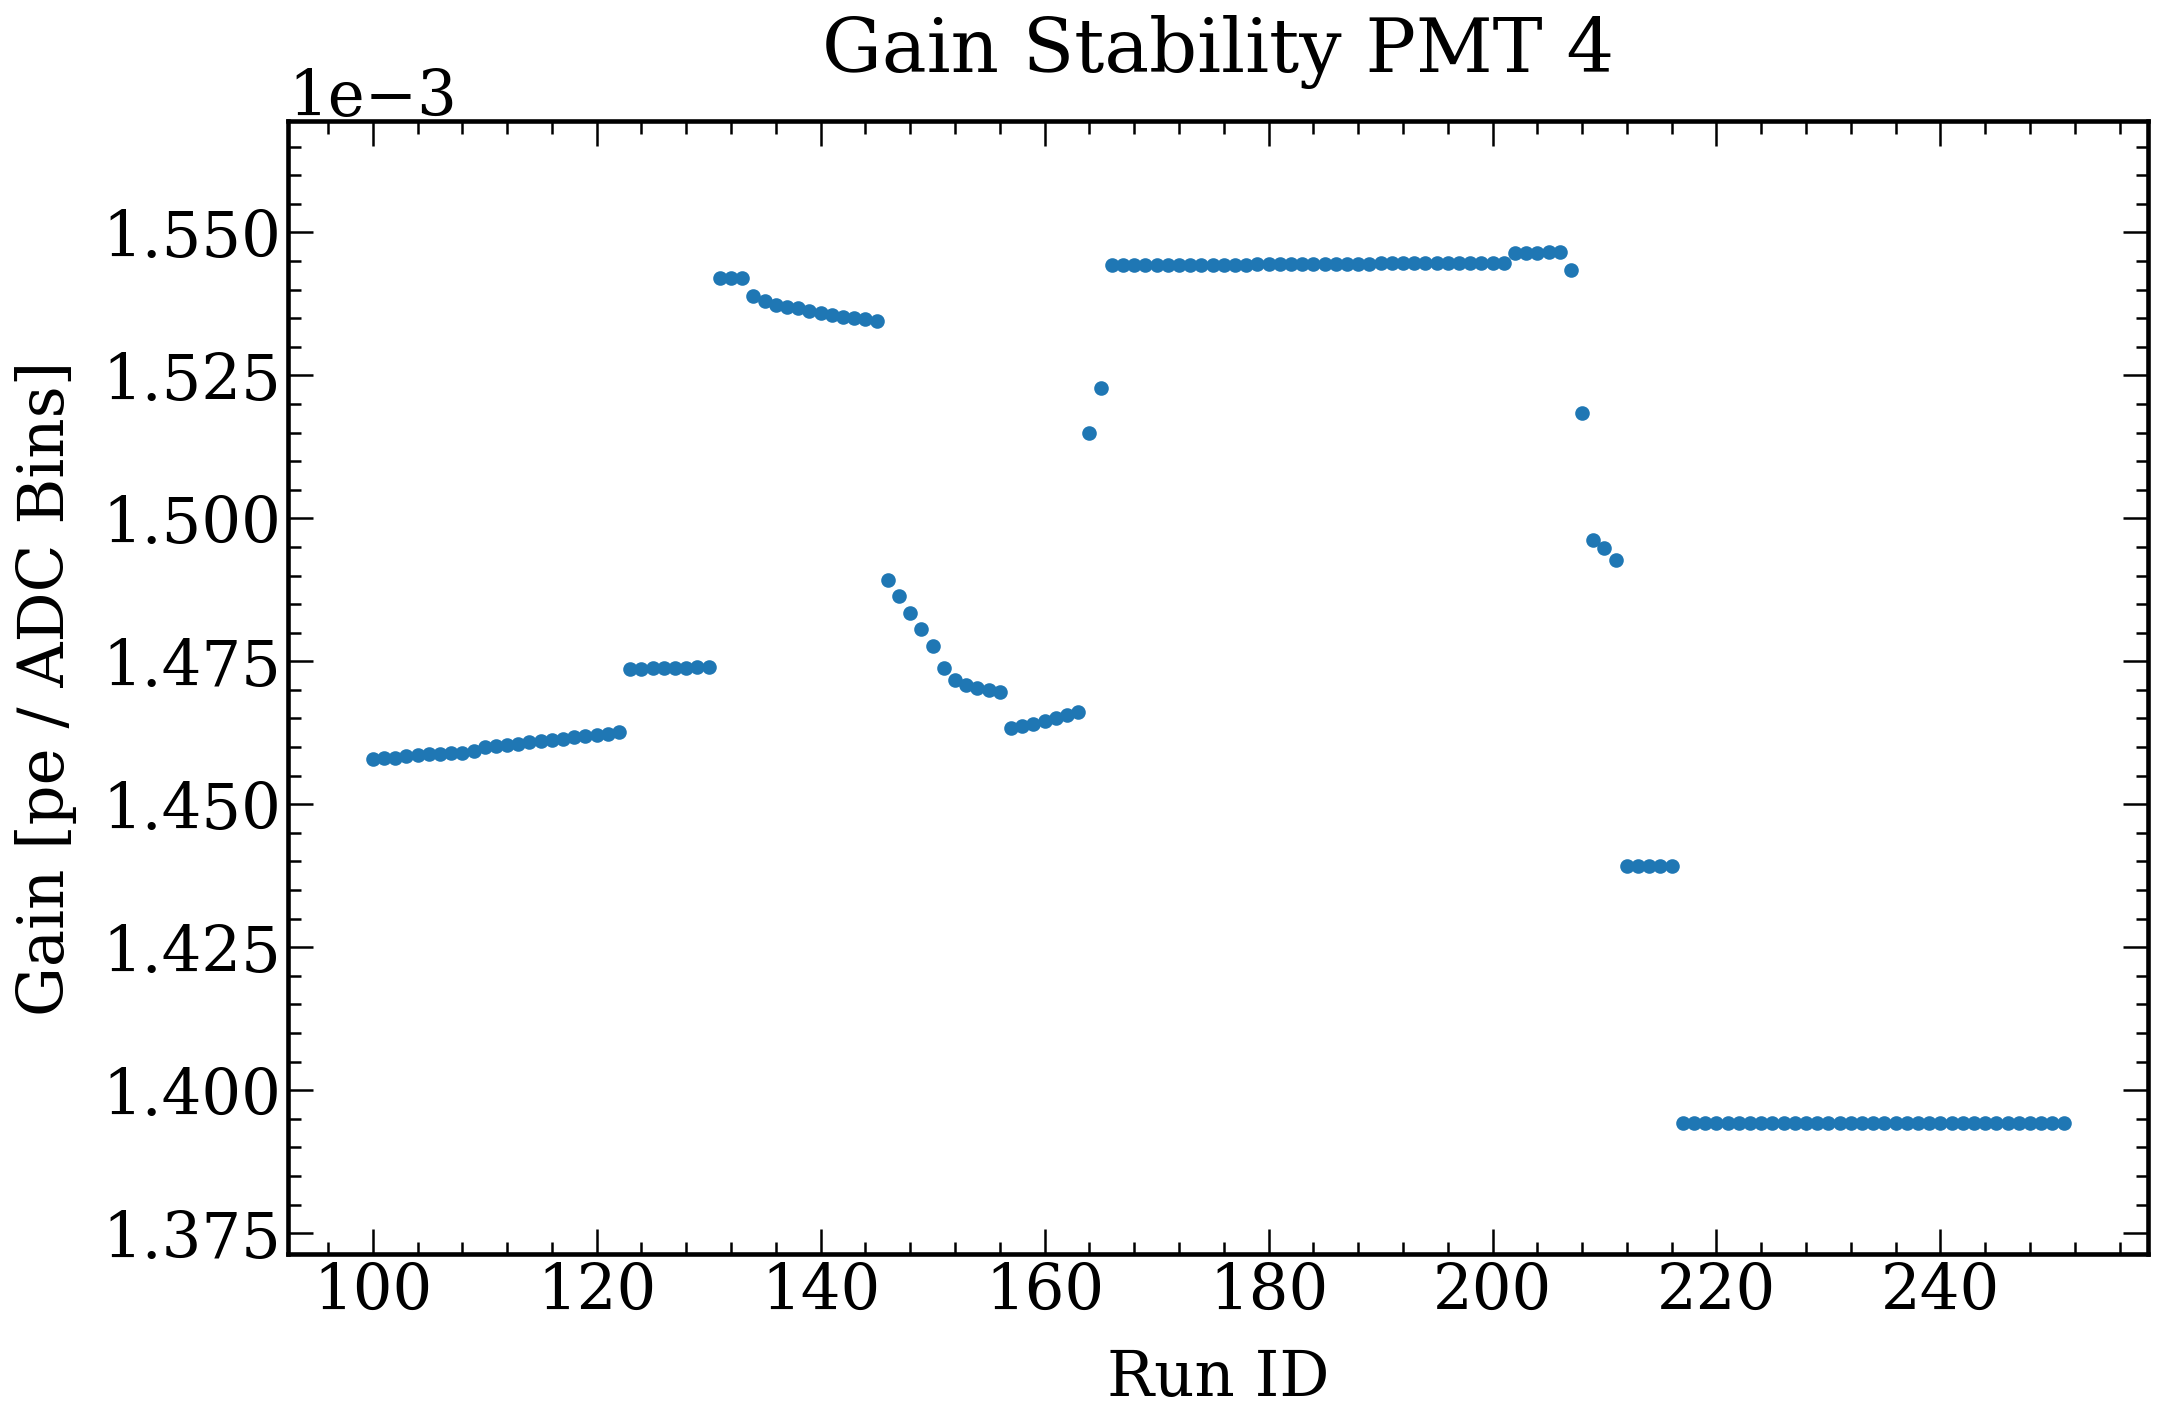

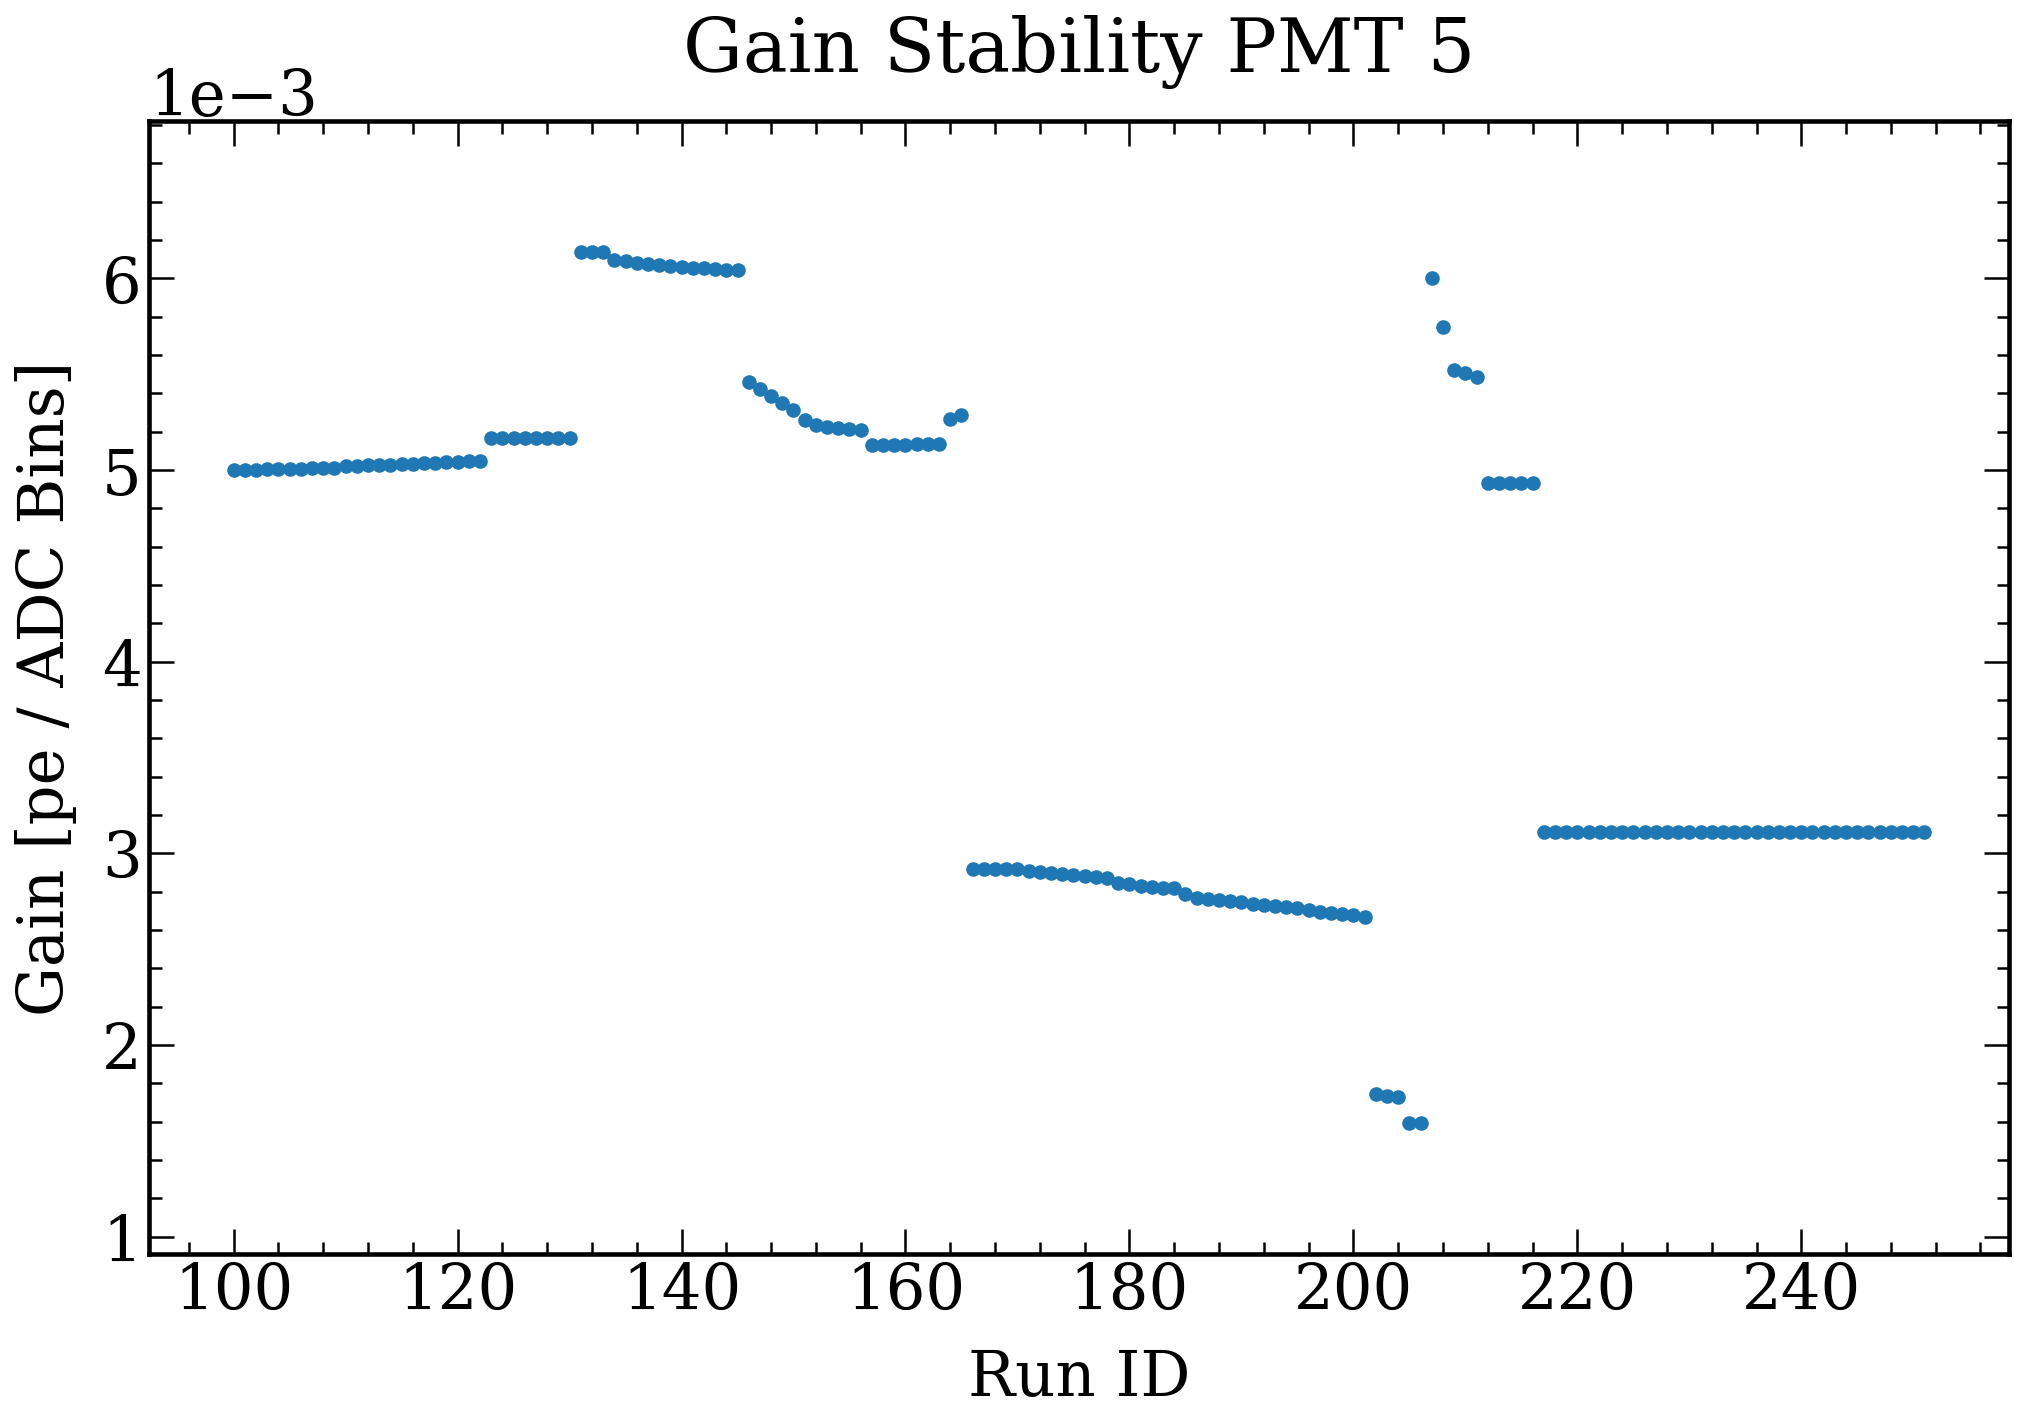

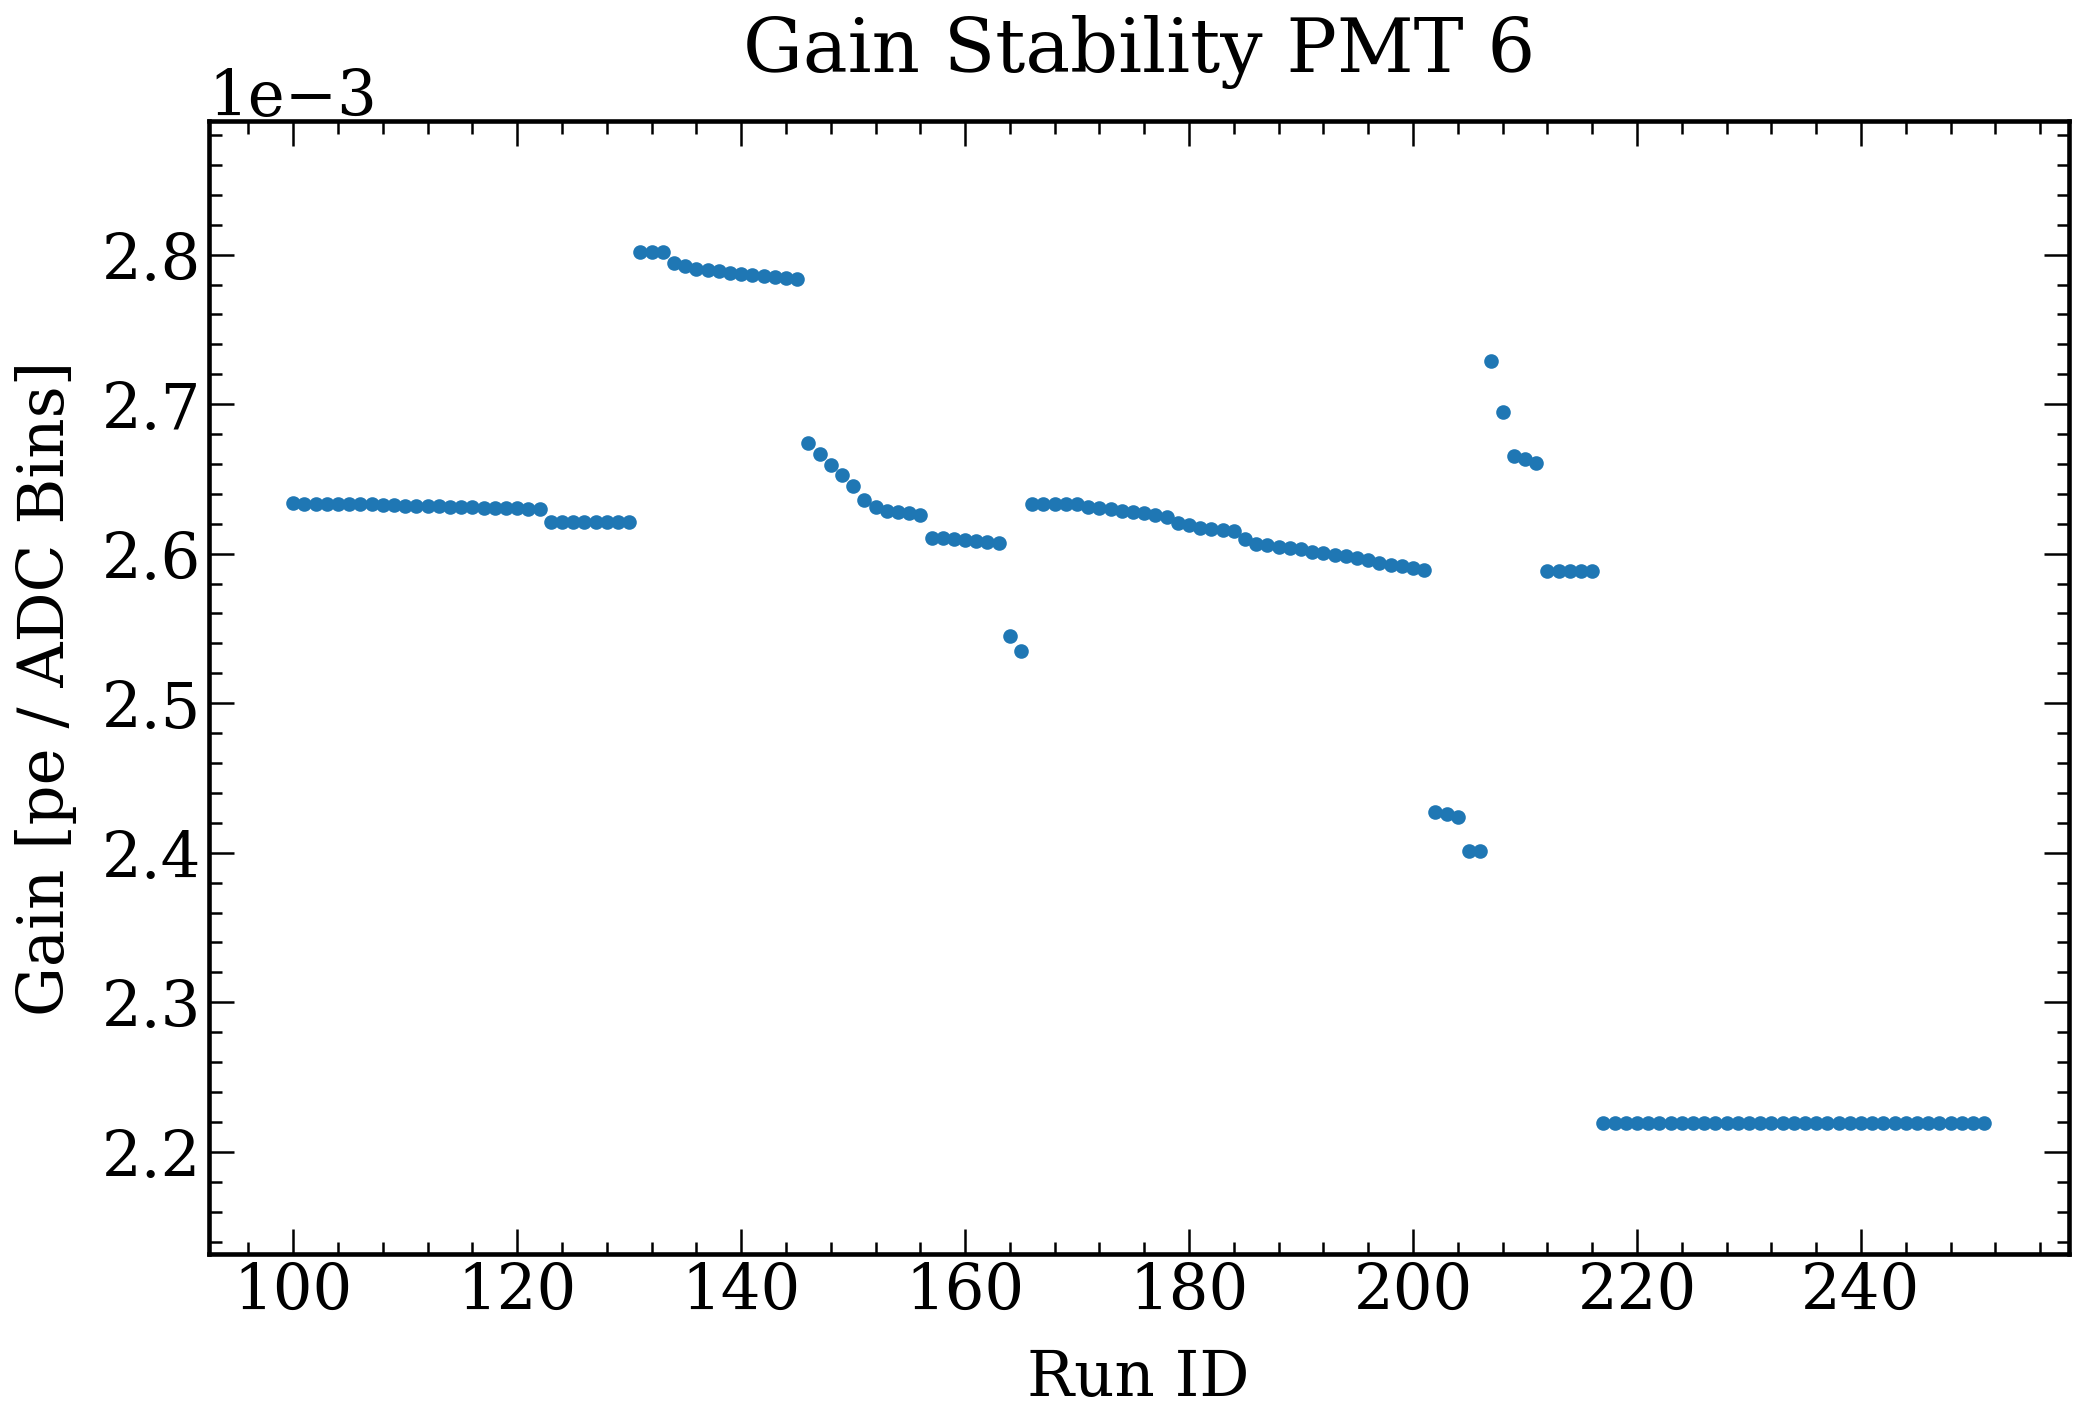

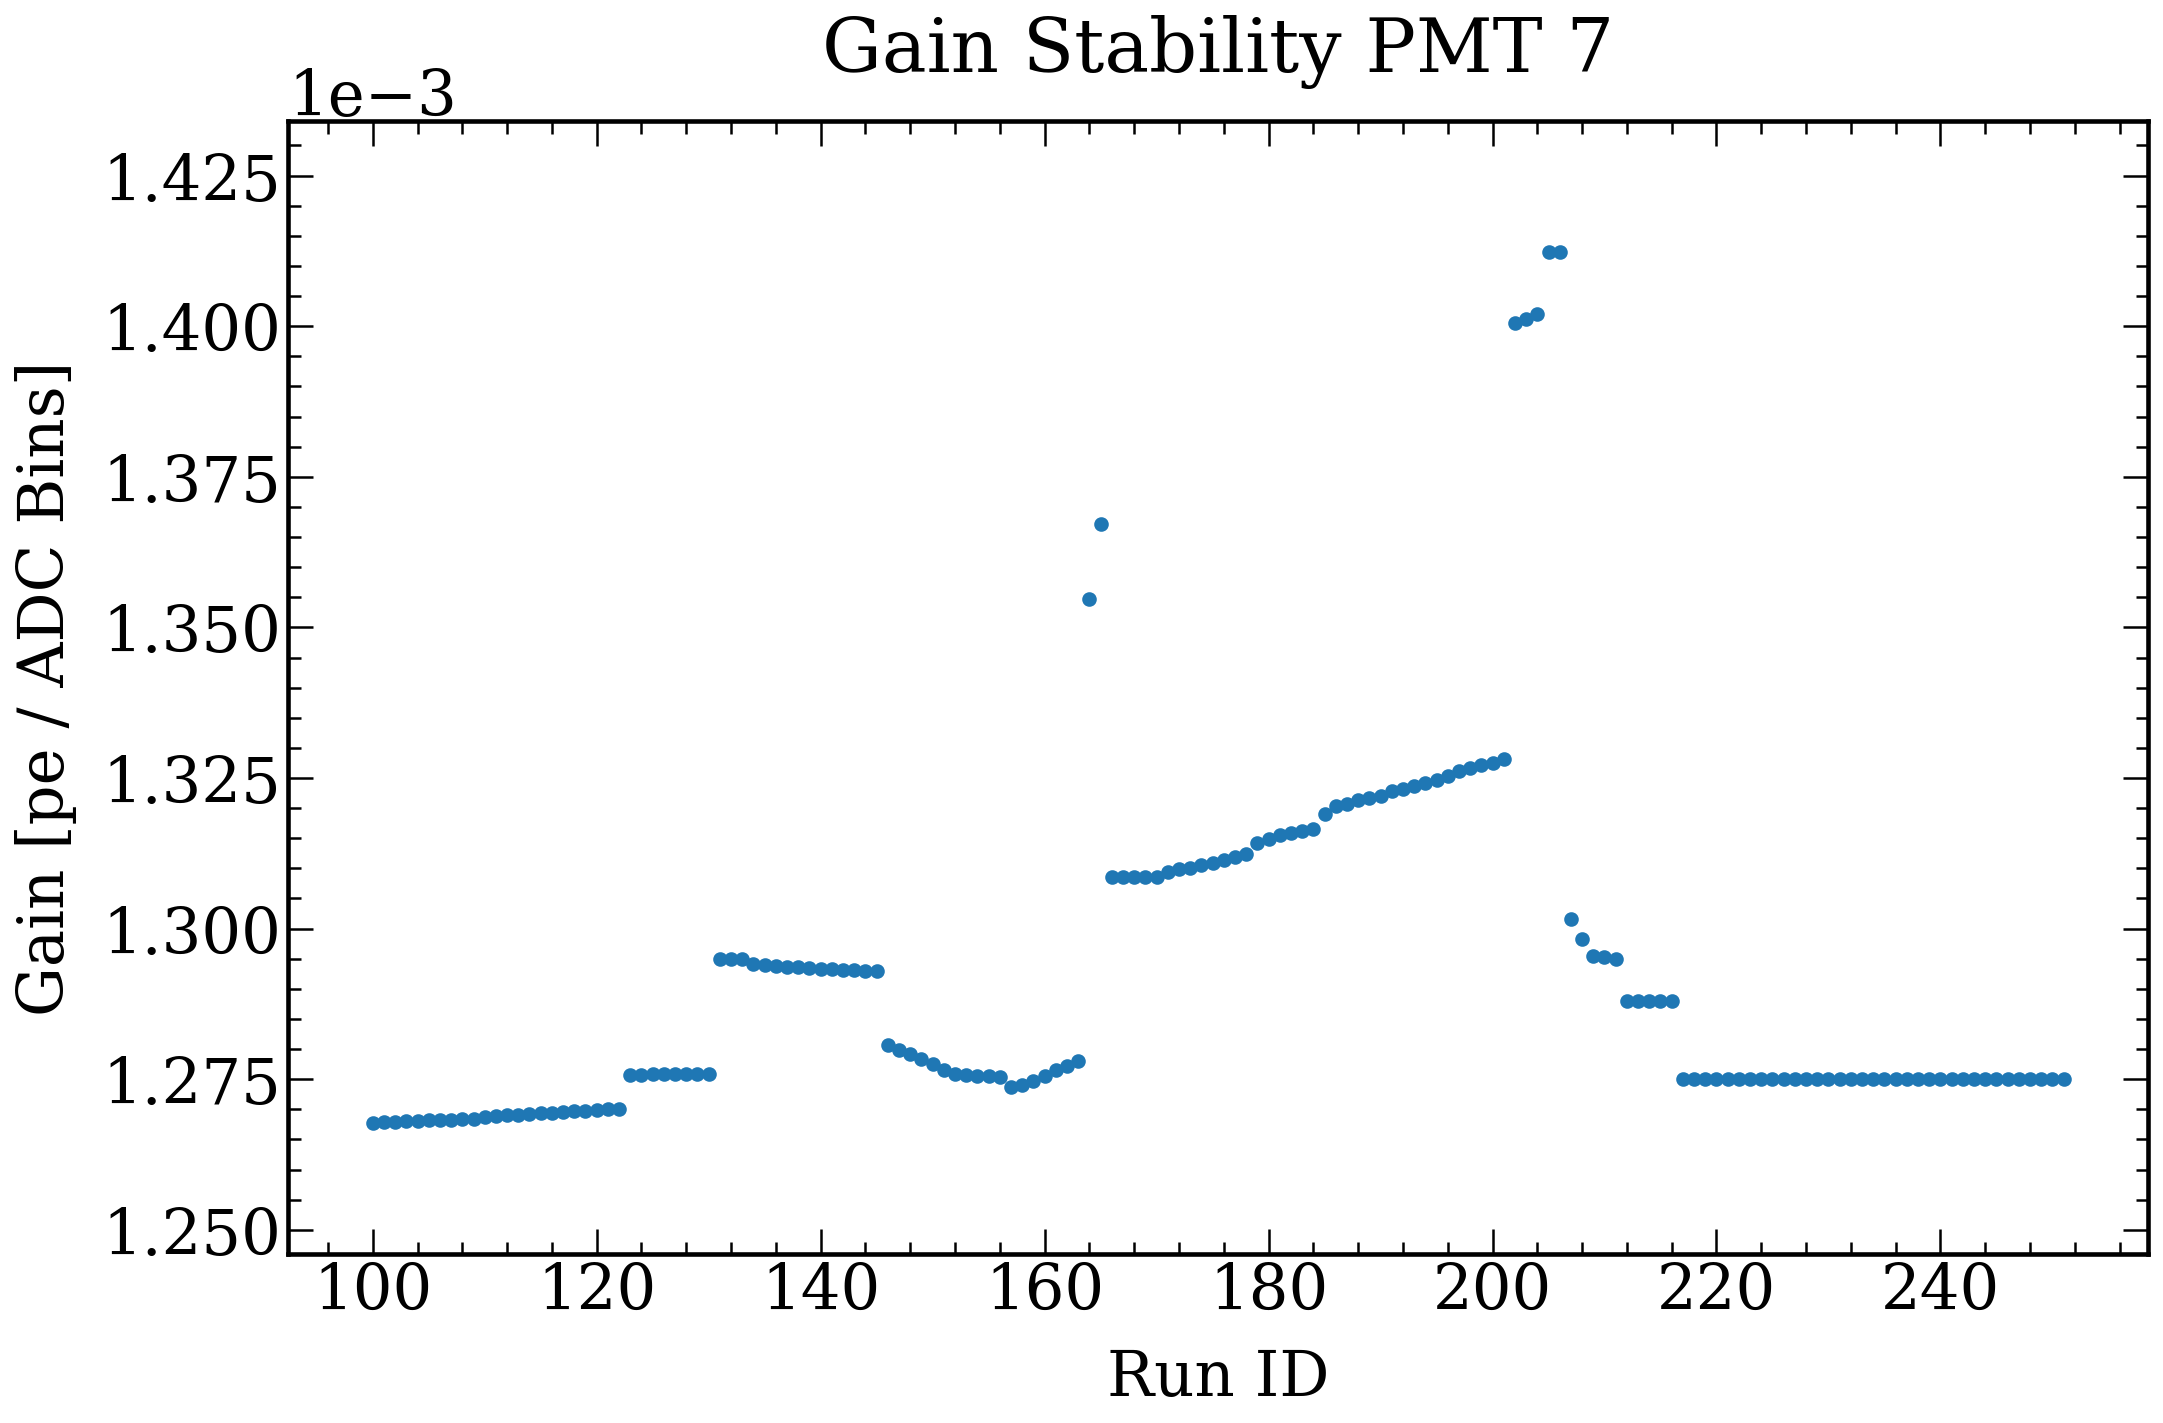

In [16]:
for pmt_id in range(0,8):

    #############################################
    ## Set plot styles:
    #############################################

    fig=plt.figure(figsize=(16, 10), dpi=150)

    # Text options
    #plt.rc('text', usetex=False)
    plt.rc('font', family='serif')

    # Labels
    label_size = 30 #25
    label_pad = 12 #10
    title_size = 36 #30
    title_pad = 24 #20

    # Axes Parameters
    axes = plt.gca()
    axes.tick_params(axis='both') 

    # Axes ---> Linewidth
    for axis in ['top','bottom','left','right']:
        axes.spines[axis].set_linewidth(2.2)

    # Axes ---> Ticks
    axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
    plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
    axes.yaxis.set_minor_locator(AutoMinorLocator(5))
    plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
    plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

    # Grid
    #plt.grid(True)
    
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

    #############################################
    ## Plot specific settings and plot data
    #############################################

    # Data plot

    plt.scatter(run_id_list, gains_interpolated_list_ampcorrected[:,pmt_id], label = 'Without 10x Amplifier')
    plt.ylim(np.min(gains_interpolated_list_ampcorrected[:,pmt_id]) - 0.15*(np.max(gains_interpolated_list_ampcorrected[:,pmt_id]) - np.min(gains_interpolated_list_ampcorrected[:,pmt_id])),
            np.max(gains_interpolated_list_ampcorrected[:,pmt_id]) + 0.15*(np.max(gains_interpolated_list_ampcorrected[:,pmt_id]) - np.min(gains_interpolated_list_ampcorrected[:,pmt_id])))

    plt.xlabel('Run ID', fontsize = label_size, labelpad = label_pad)
    plt.ylabel('Gain [pe / ADC Bins]', fontsize = label_size, labelpad = label_pad)
    plt.title('Gain Stability PMT '+str(pmt_id), fontsize = title_size, pad = title_pad)

    # Legend
    '''leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False, 
                    title = 'PMT ID')
    for line in leg.get_lines(): # enumerated
        line.set_linewidth(4)
    leg.get_frame().set_linewidth(2.5)
    leg._legend_box.align = "left"'''

    plt.show()

    fig.savefig("Gain Stability_PMT_"+str(pmt_id)+".png")

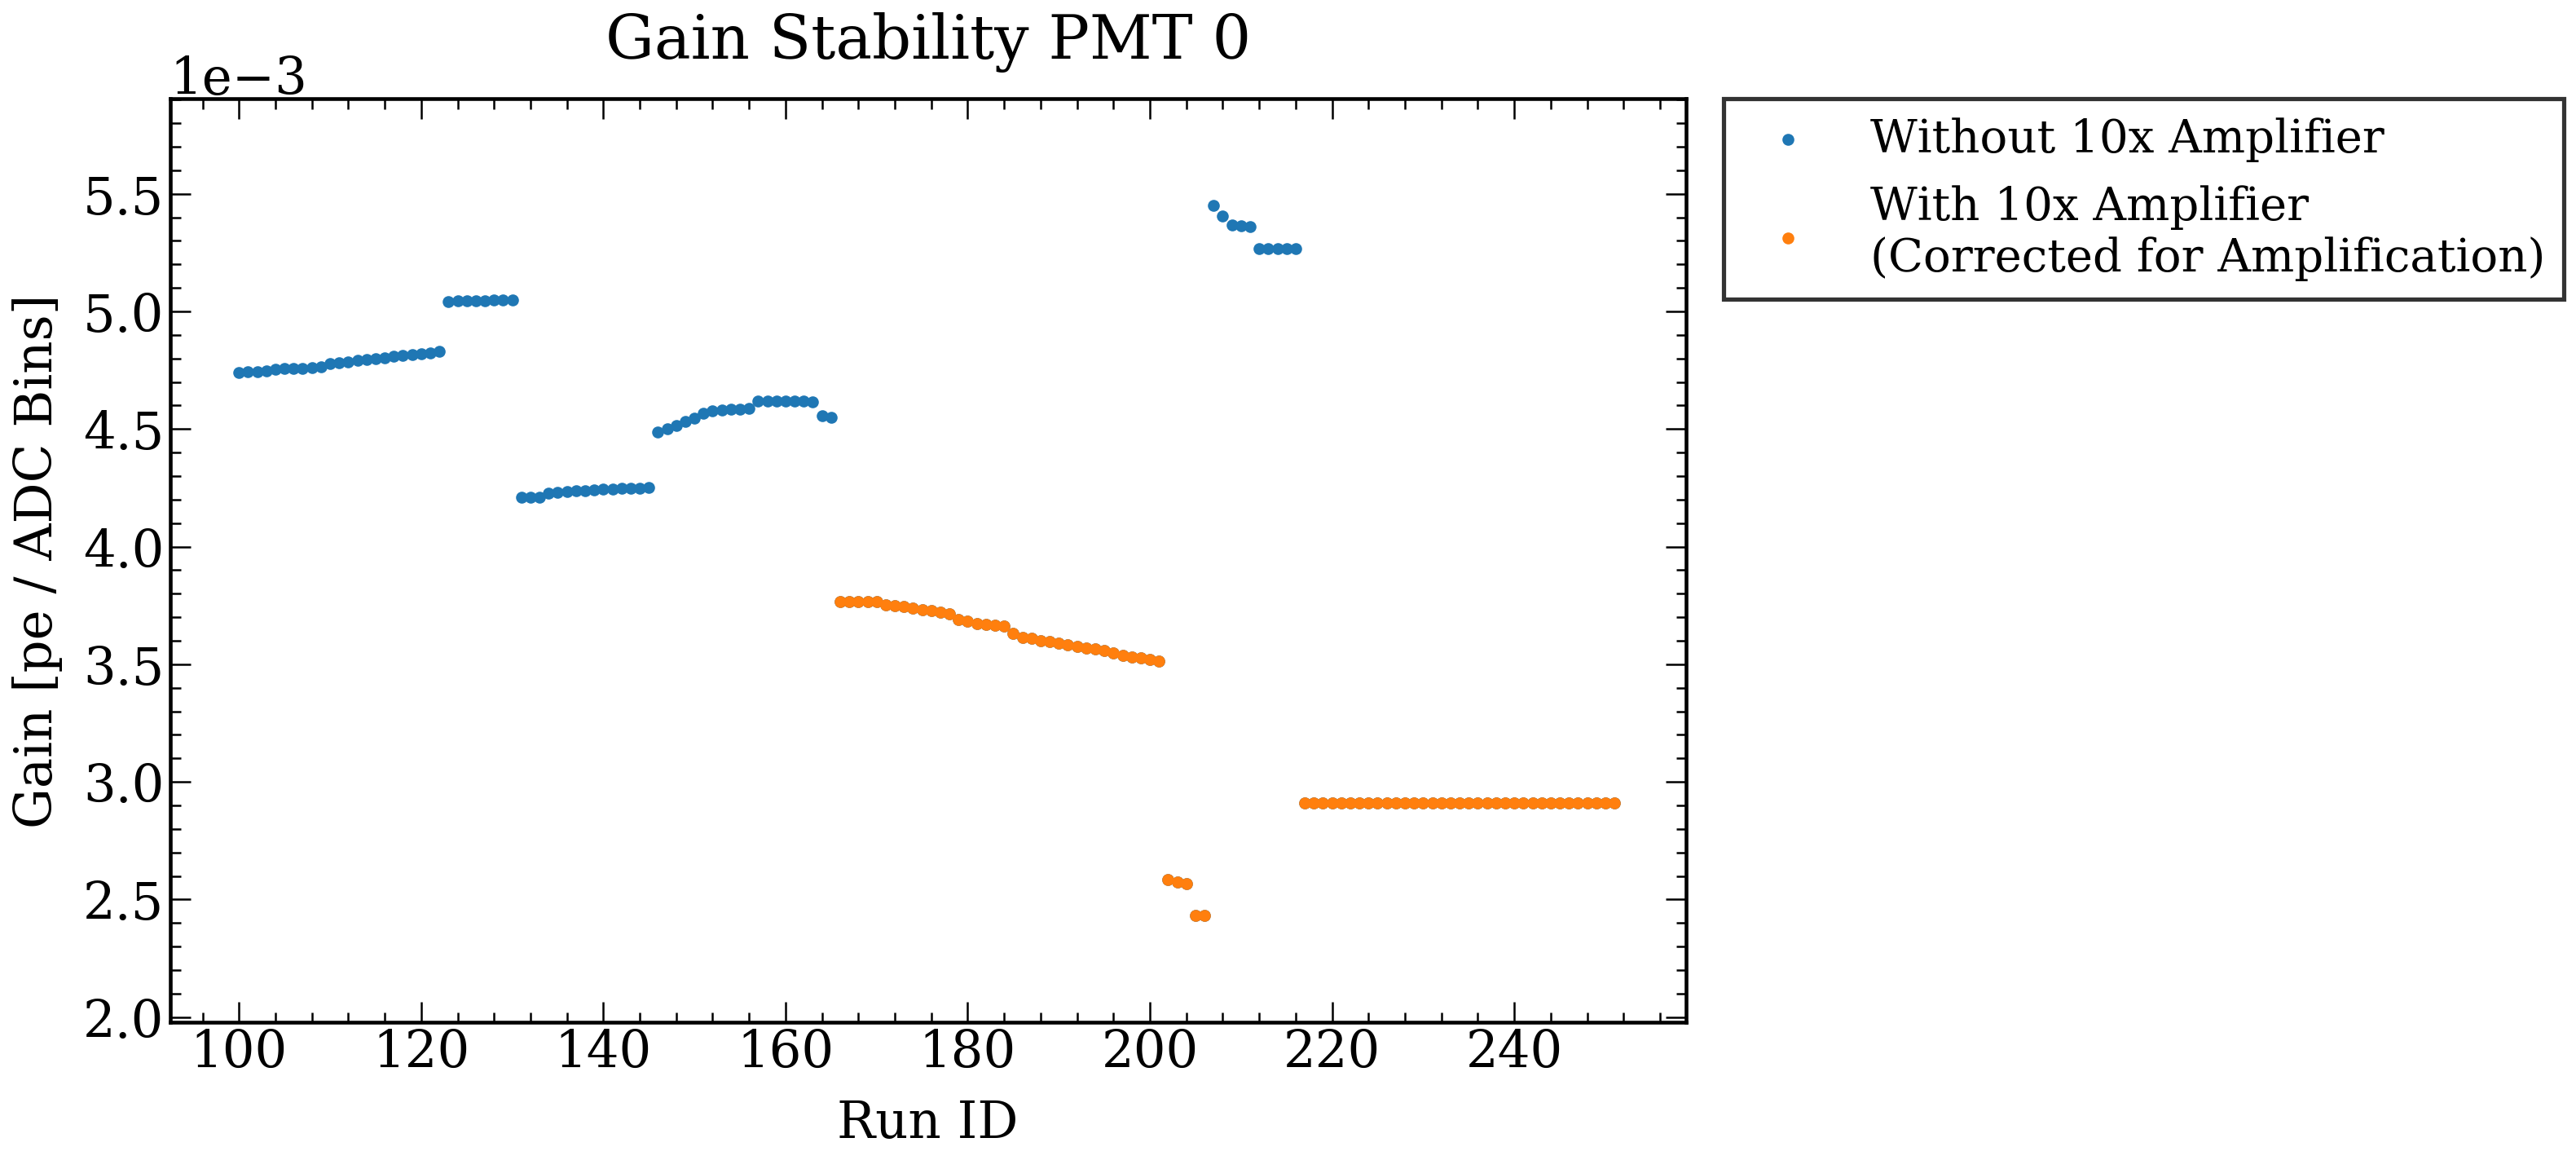

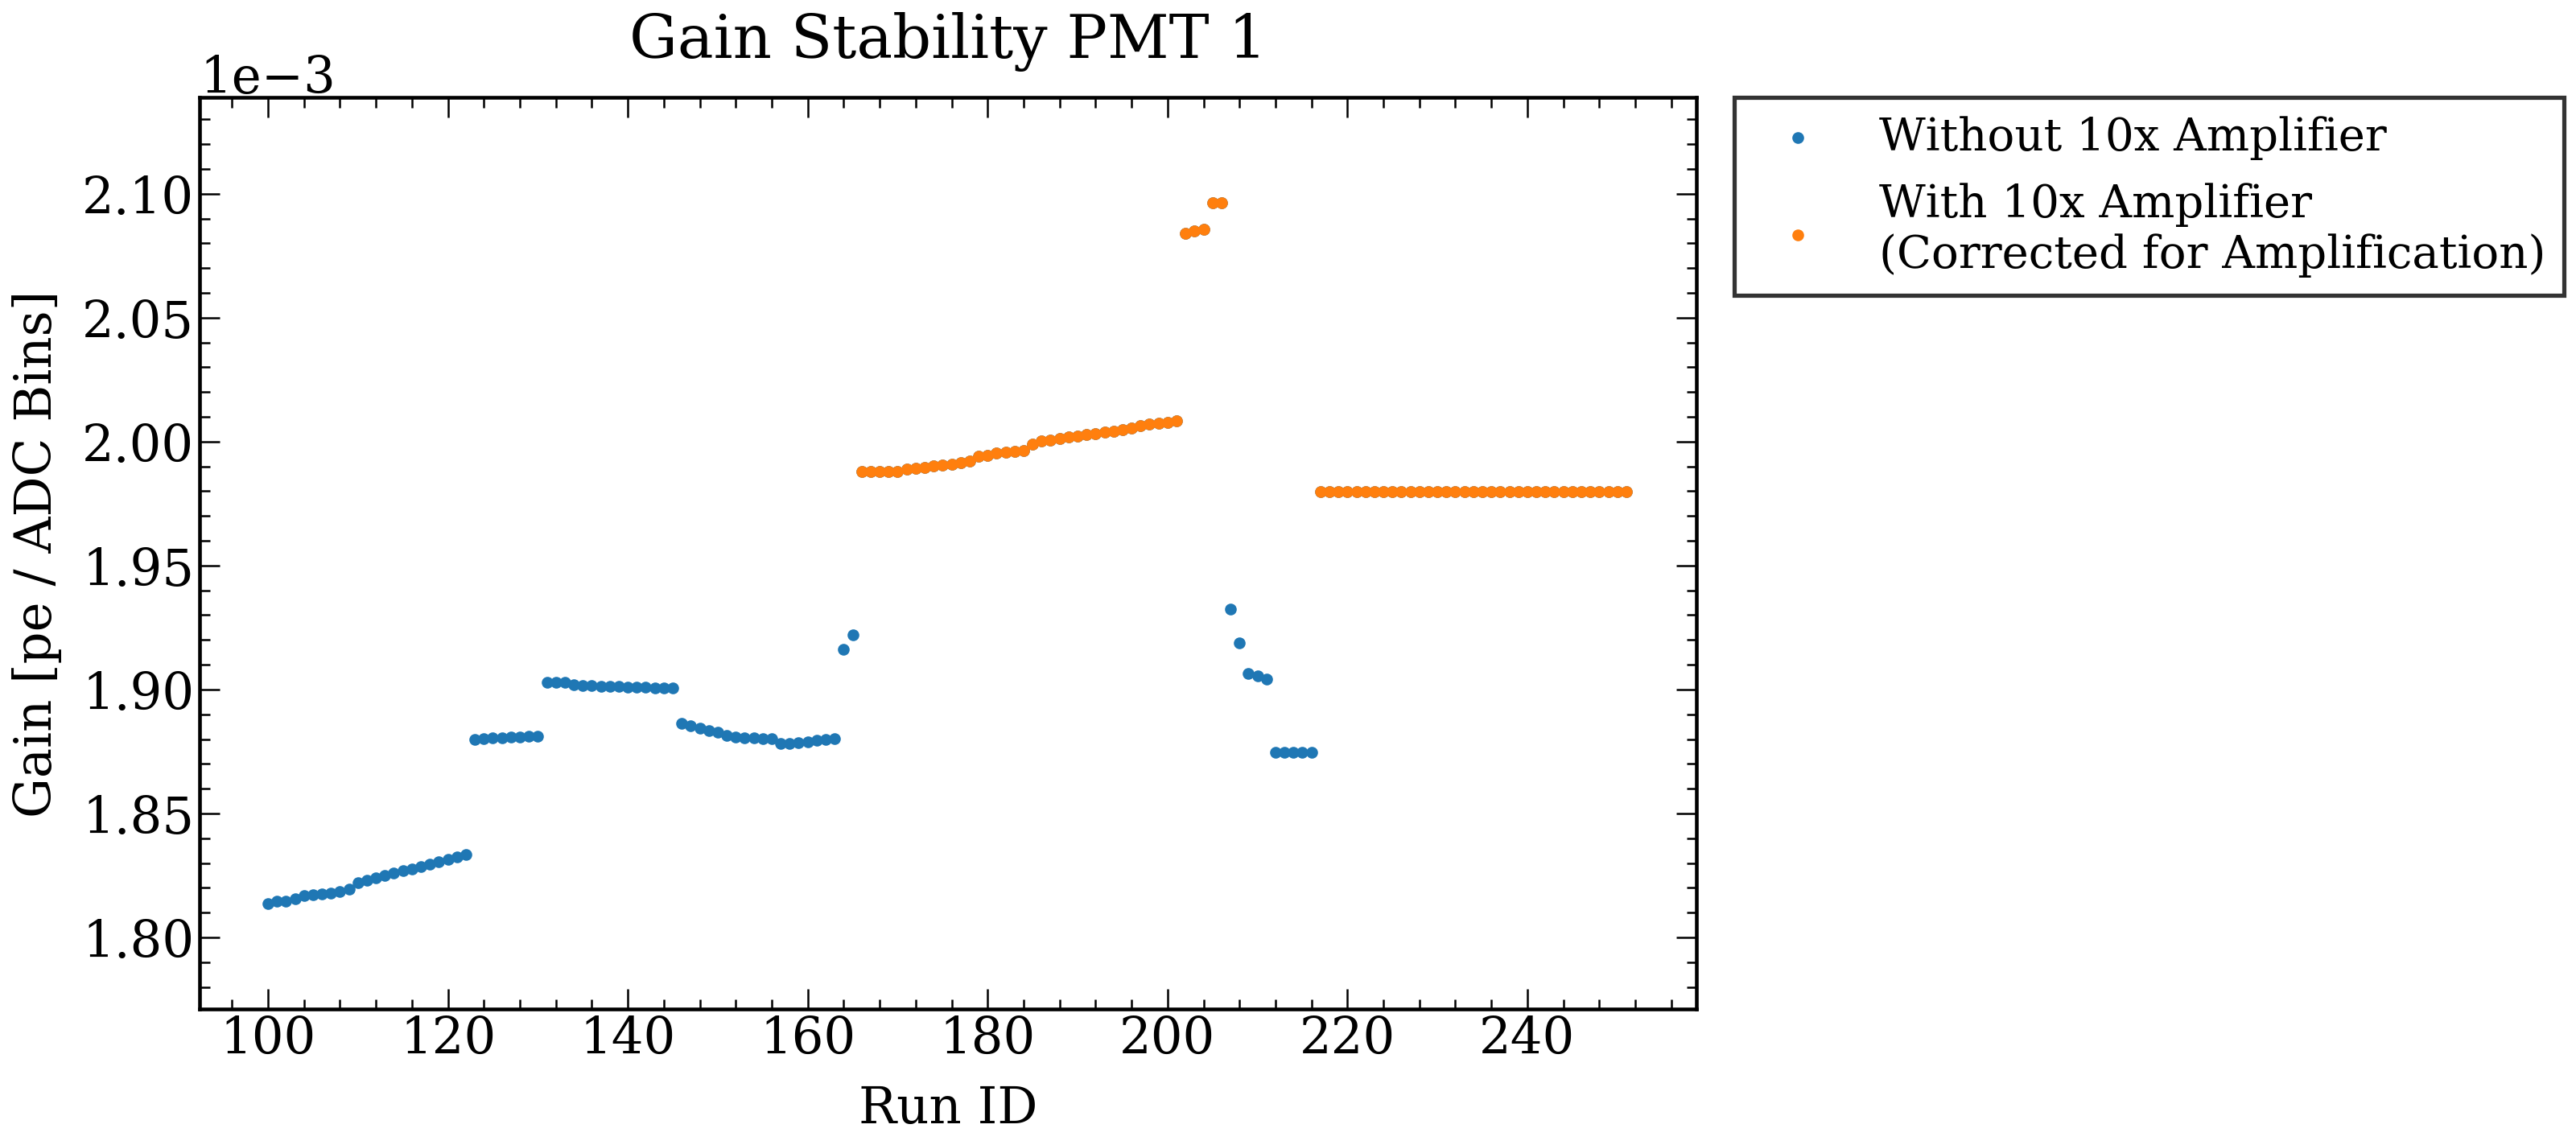

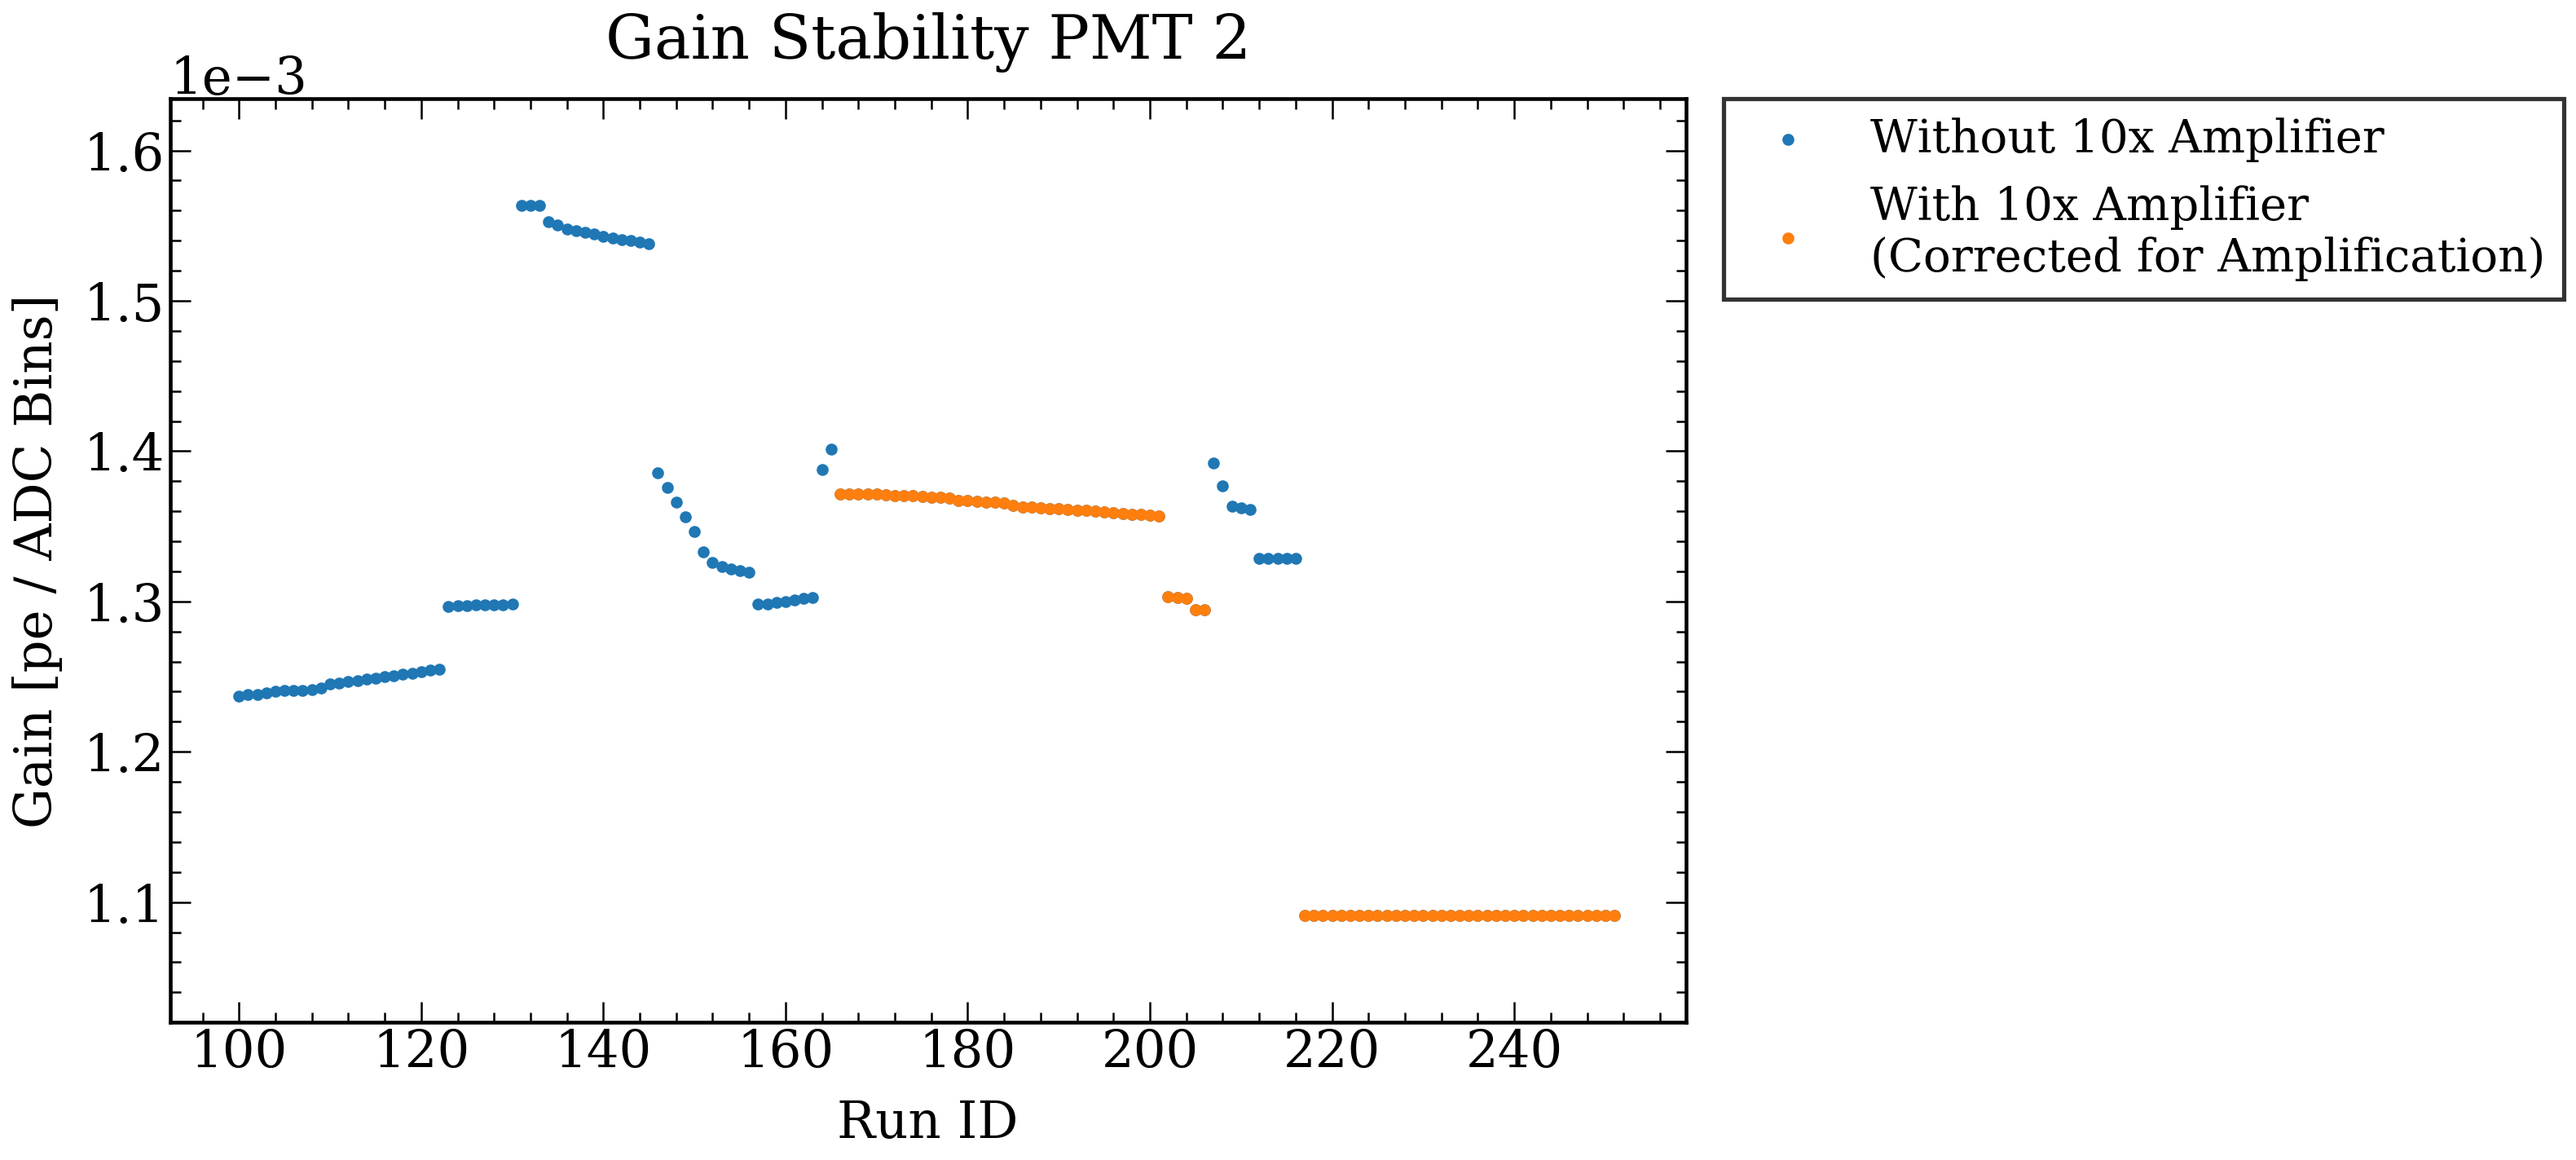

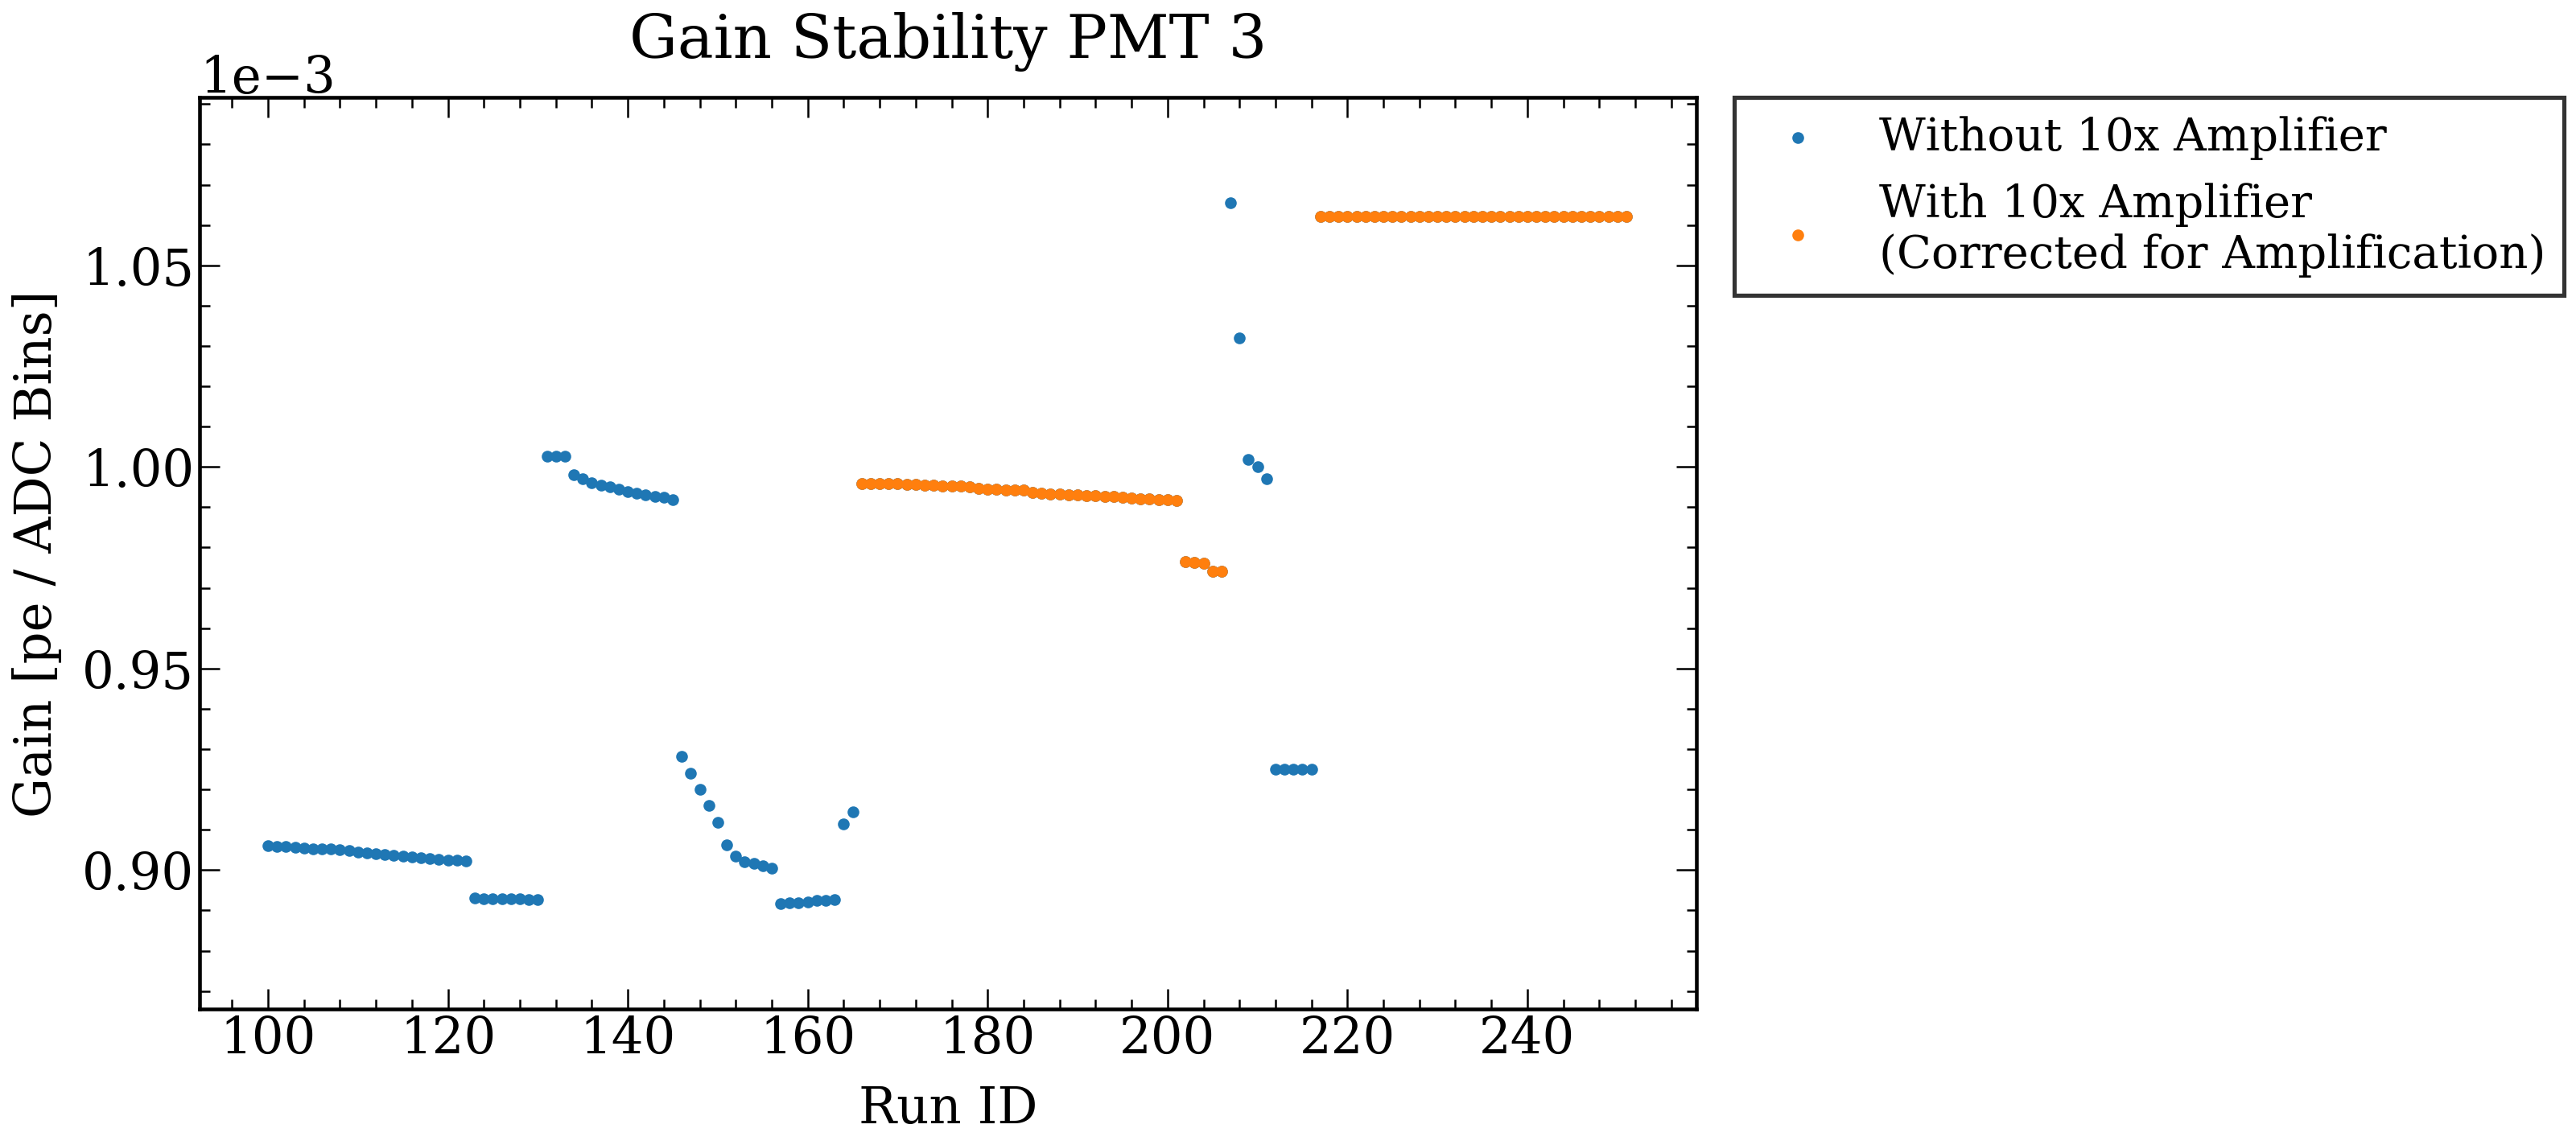

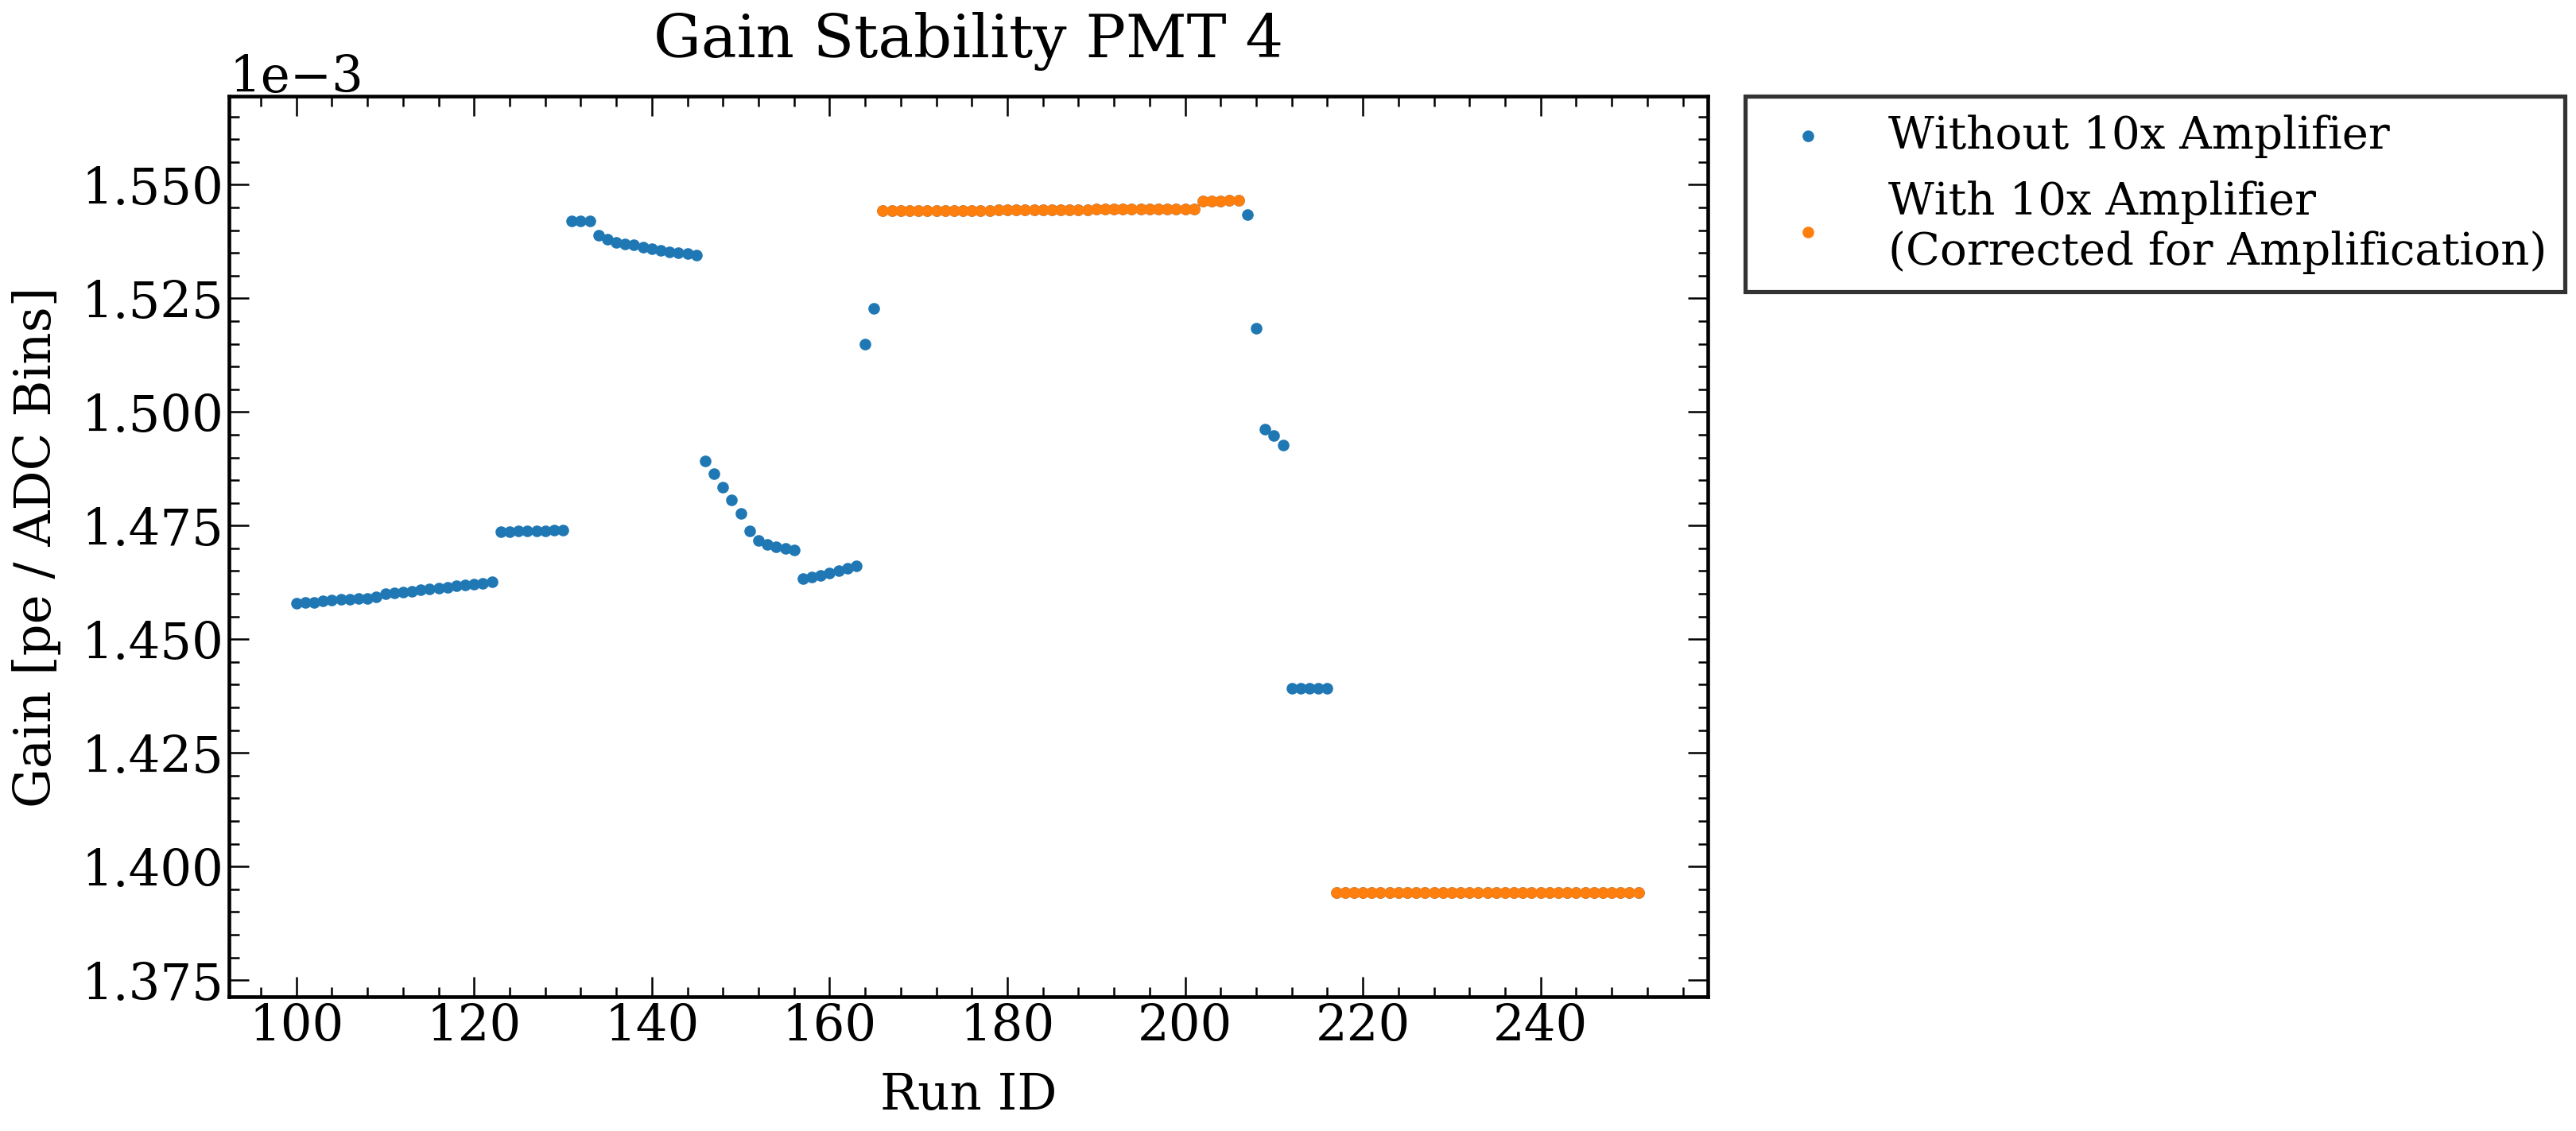

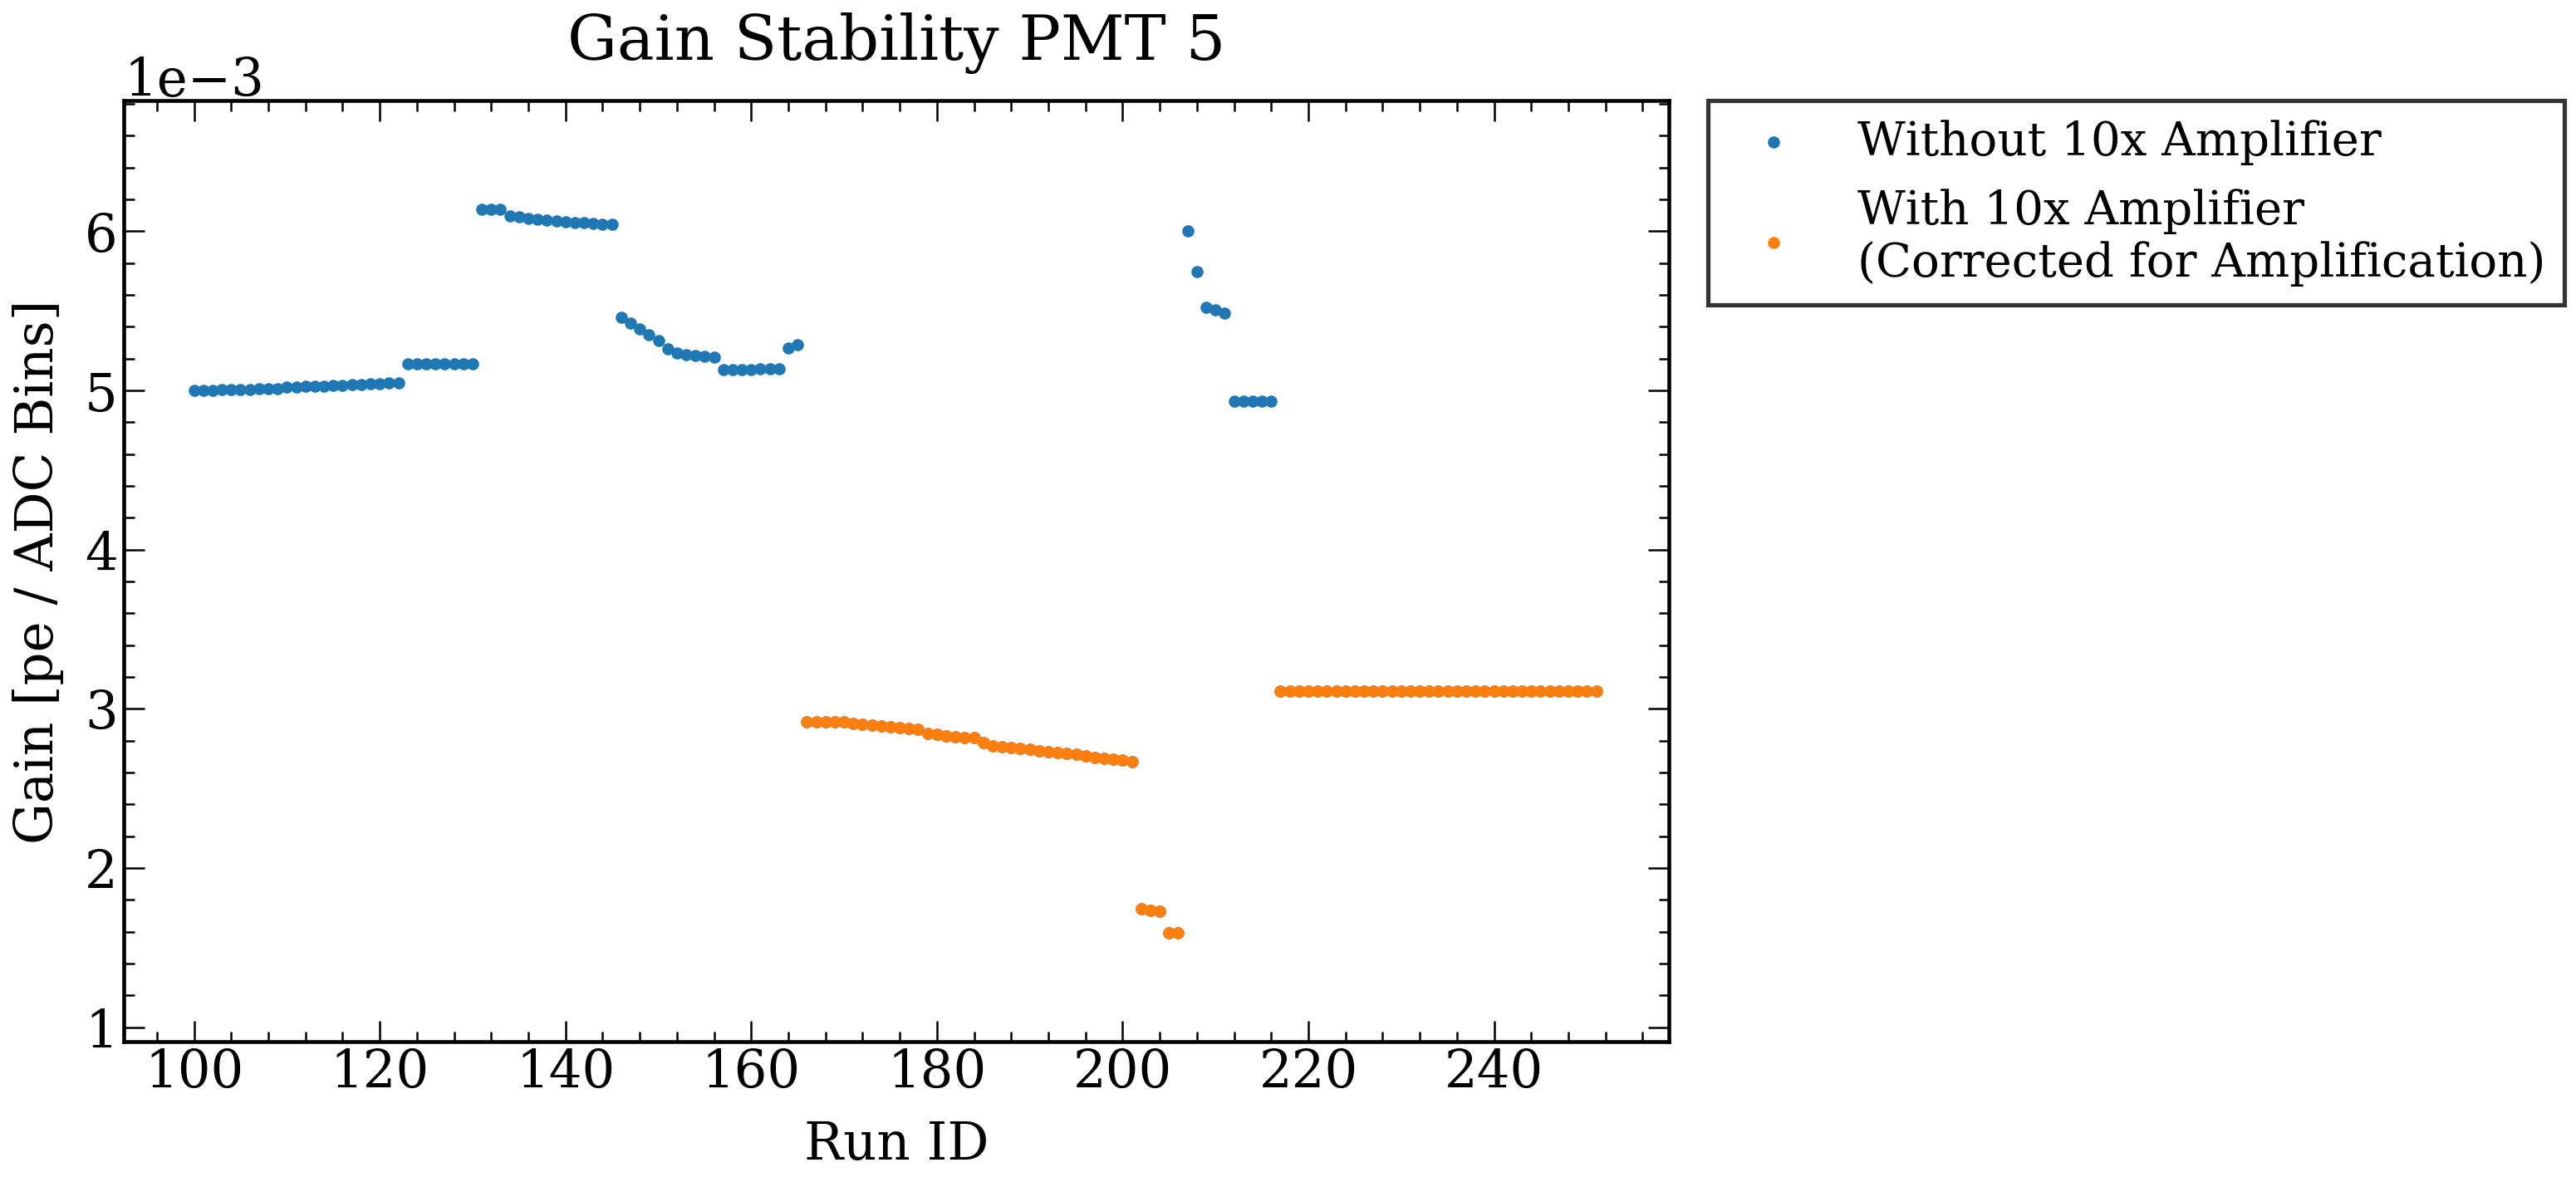

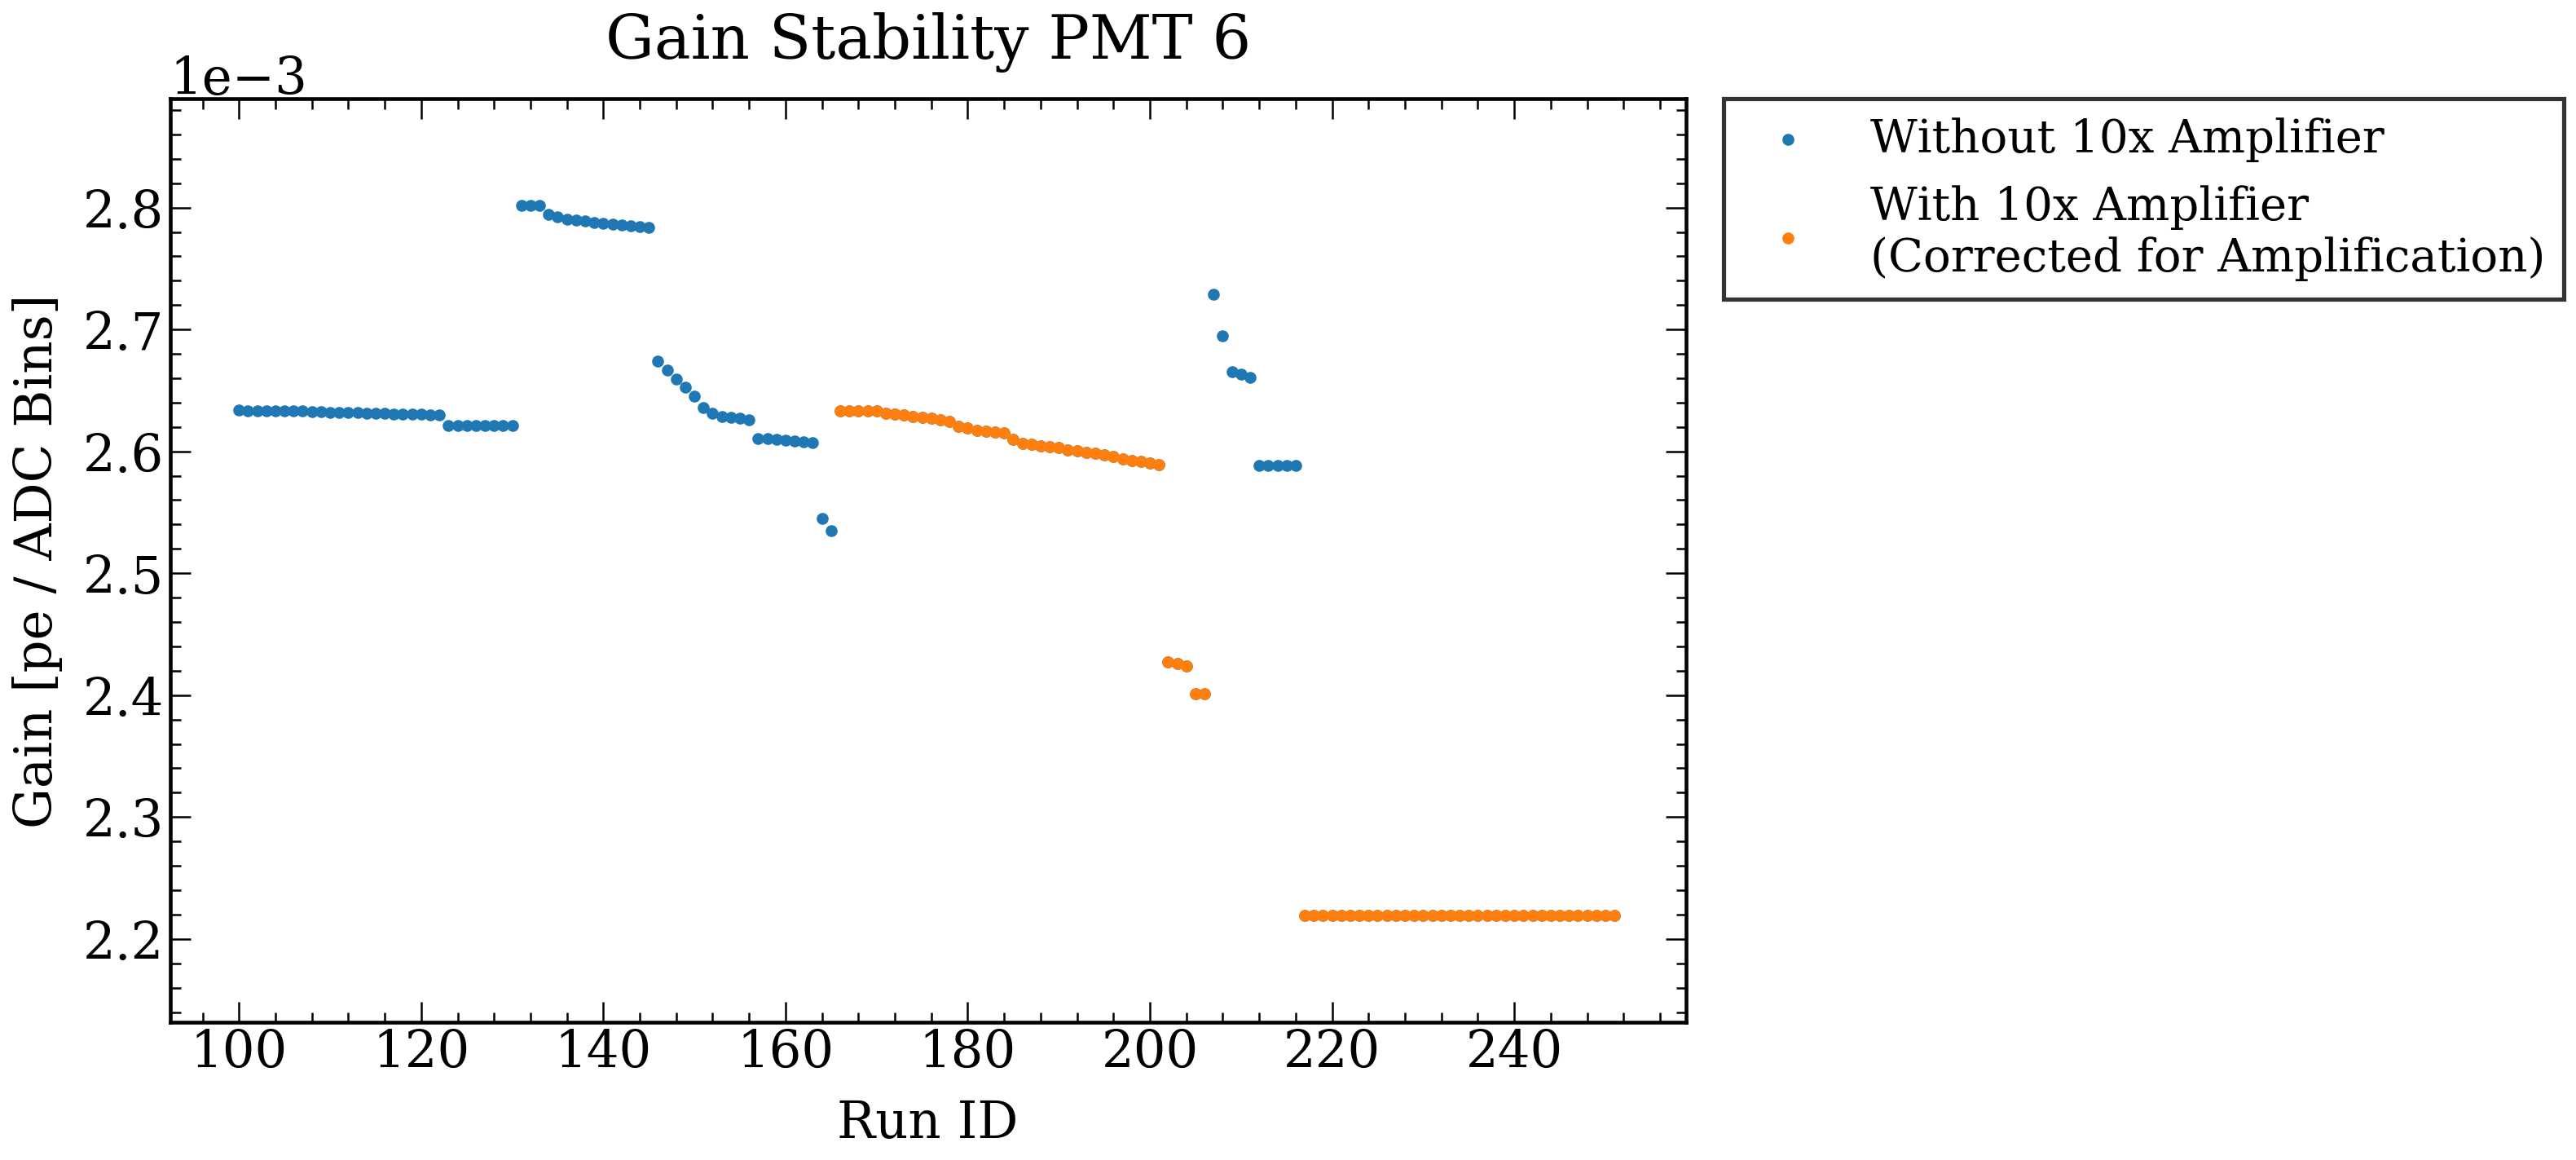

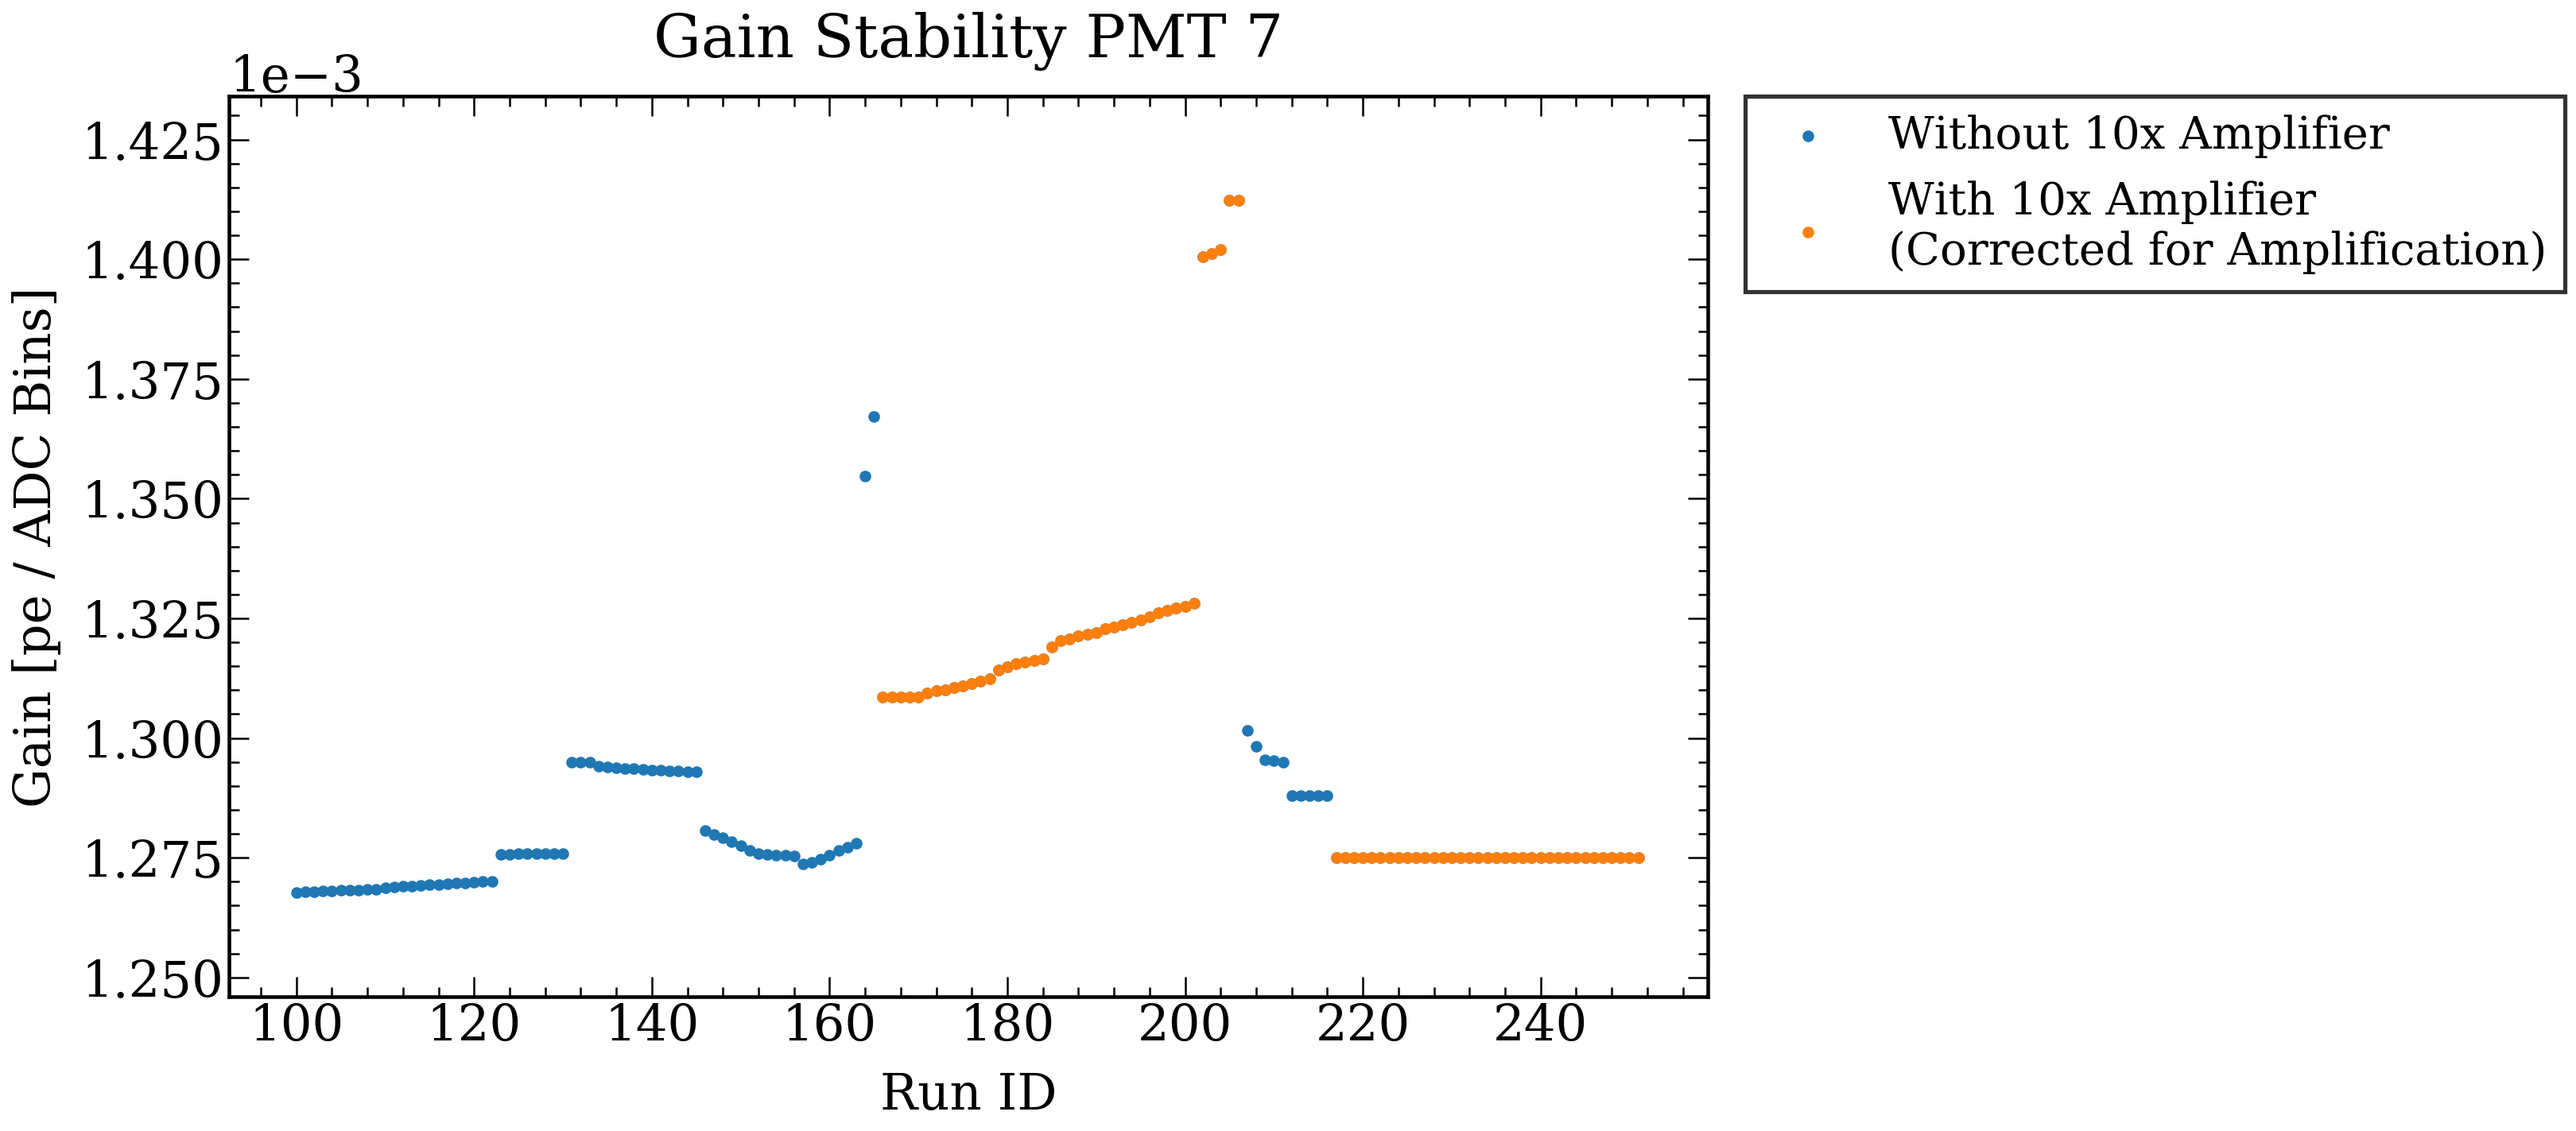

In [17]:
for pmt_id in range(0,8):

    #############################################
    ## Set plot styles:
    #############################################

    fig=plt.figure(figsize=(16, 10), dpi=150)

    # Text options
    #plt.rc('text', usetex=False)
    plt.rc('font', family='serif')

    # Labels
    label_size = 30 #25
    label_pad = 12 #10
    title_size = 36 #30
    title_pad = 24 #20

    # Axes Parameters
    axes = plt.gca()
    axes.tick_params(axis='both') 

    # Axes ---> Linewidth
    for axis in ['top','bottom','left','right']:
        axes.spines[axis].set_linewidth(2.2)

    # Axes ---> Ticks
    axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
    plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
    axes.yaxis.set_minor_locator(AutoMinorLocator(5))
    plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
    plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

    # Grid
    #plt.grid(True)
    
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

    #############################################
    ## Plot specific settings and plot data
    #############################################

    # Data plot

    plt.scatter(run_id_list, gains_interpolated_list_ampcorrected[:,pmt_id], label = 'Without 10x Amplifier')
    plt.scatter(run_id_list[gains_interpolated_list[:,0] > 0.015], (gains_interpolated_list_ampcorrected[:,pmt_id][gains_interpolated_list[:,0] > 0.015]), label = 'With 10x Amplifier\n(Corrected for Amplification)')
    plt.ylim(np.min(gains_interpolated_list_ampcorrected[:,pmt_id]) - 0.15*(np.max(gains_interpolated_list_ampcorrected[:,pmt_id]) - np.min(gains_interpolated_list_ampcorrected[:,pmt_id])),
            np.max(gains_interpolated_list_ampcorrected[:,pmt_id]) + 0.15*(np.max(gains_interpolated_list_ampcorrected[:,pmt_id]) - np.min(gains_interpolated_list_ampcorrected[:,pmt_id])))

    plt.xlabel('Run ID', fontsize = label_size, labelpad = label_pad)
    plt.ylabel('Gain [pe / ADC Bins]', fontsize = label_size, labelpad = label_pad)
    plt.title('Gain Stability PMT '+str(pmt_id), fontsize = title_size, pad = title_pad)

    # Legend
    leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
    for line in leg.get_lines(): # enumerated
        line.set_linewidth(4)
    leg.get_frame().set_linewidth(2.5)
    leg._legend_box.align = "left"

    plt.show()

    fig.savefig("Gain Stability_PMT_"+str(pmt_id)+"_AmpMarked.png", bbox_inches='tight')

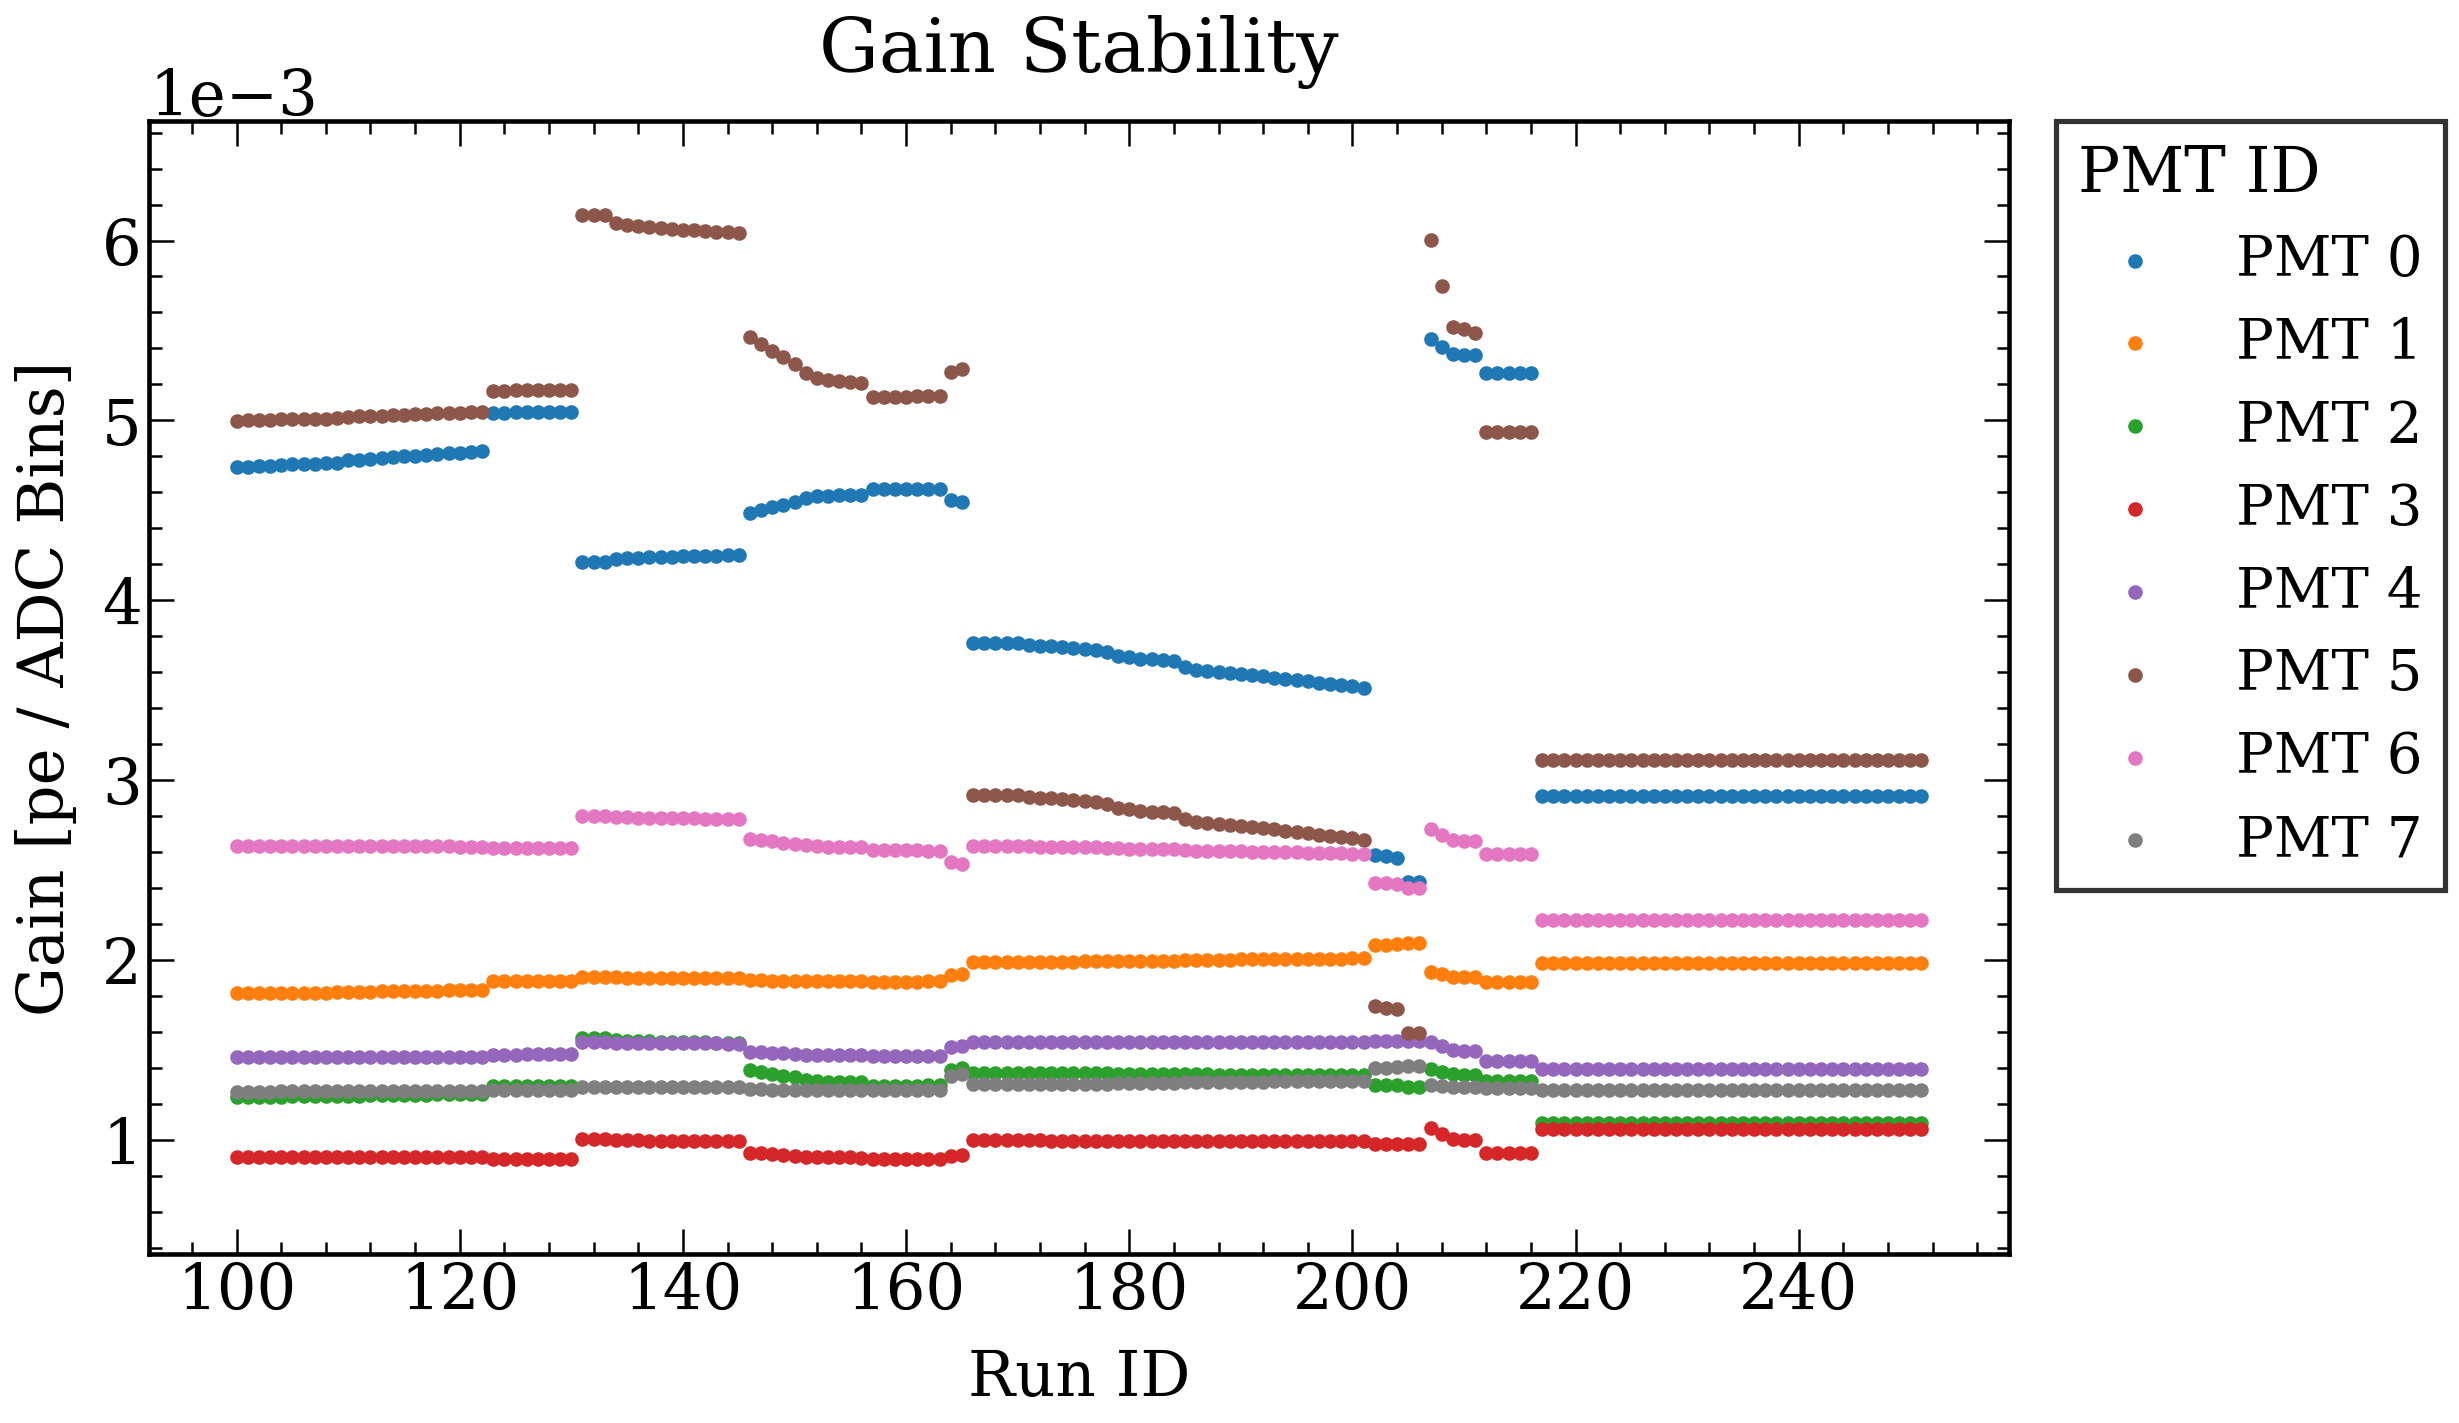

In [18]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
#plt.rc('text', usetex=False)
plt.rc('font', family='serif')

# Labels
label_size = 30 #25
label_pad = 12 #10
title_size = 36 #30
title_pad = 24 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)

# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

#############################################
## Plot specific settings and plot data
#############################################

# Data plot

for pmt_id in range(0,8):
    plt.scatter(run_id_list, gains_interpolated_list_ampcorrected[:,pmt_id], label = 'PMT '+str(pmt_id))


plt.ylim(np.amin(gains_interpolated_list_ampcorrected) - 0.1*(np.amax(gains_interpolated_list_ampcorrected) - np.amin(gains_interpolated_list_ampcorrected)),
        np.amax(gains_interpolated_list_ampcorrected) + 0.1*(np.amax(gains_interpolated_list_ampcorrected) - np.amin(gains_interpolated_list_ampcorrected)))

plt.xlabel('Run ID', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Gain [pe / ADC Bins]', fontsize = label_size, labelpad = label_pad)
plt.title('Gain Stability', fontsize = title_size, pad = title_pad)

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False, 
                title = 'PMT ID')
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

plt.show()

fig.savefig("Gain Stability_PMT.png", bbox_inches='tight')

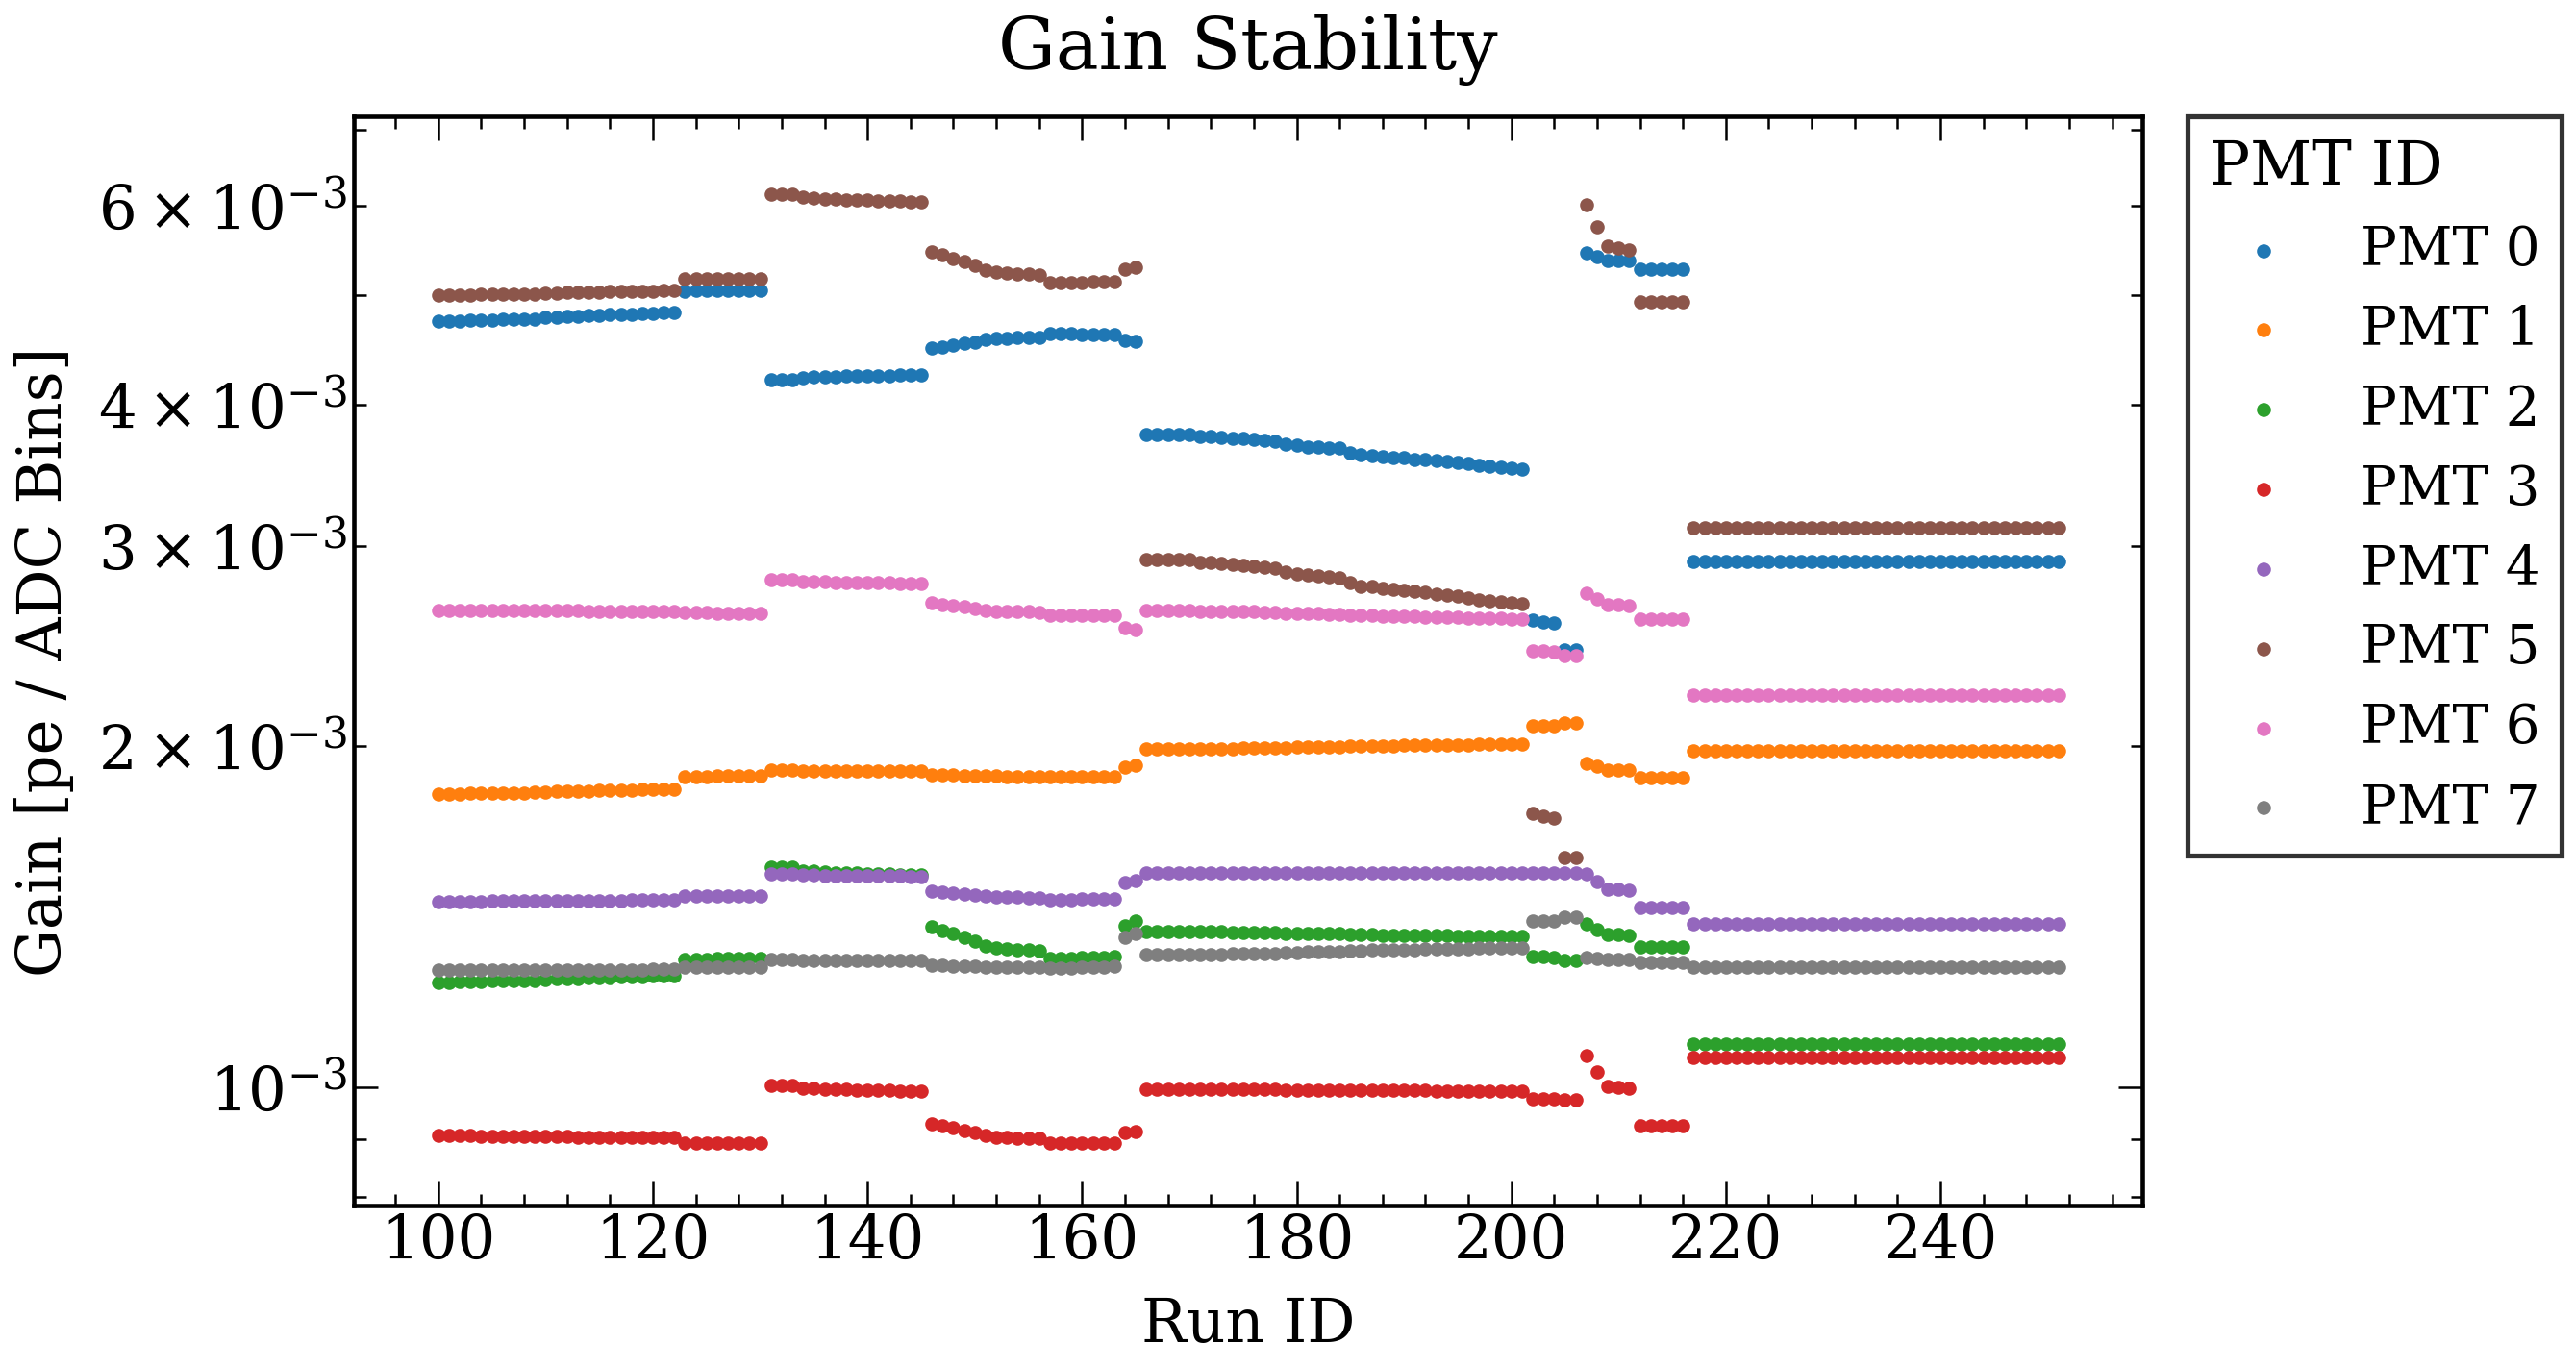

In [19]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
#plt.rc('text', usetex=False)
plt.rc('font', family='serif')

# Labels
label_size = 30 #25
label_pad = 12 #10
title_size = 36 #30
title_pad = 24 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)

# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

#############################################
## Plot specific settings and plot data
#############################################

# Data plot

for pmt_id in range(0,8):
    plt.scatter(run_id_list, gains_interpolated_list_ampcorrected[:,pmt_id], label = 'PMT '+str(pmt_id))

plt.yscale('log')
plt.ylim(np.amin(gains_interpolated_list_ampcorrected) - 0.02*(np.amax(gains_interpolated_list_ampcorrected) - np.amin(gains_interpolated_list_ampcorrected)),
        np.amax(gains_interpolated_list_ampcorrected) + 0.2*(np.amax(gains_interpolated_list_ampcorrected) - np.amin(gains_interpolated_list_ampcorrected)))

plt.xlabel('Run ID', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Gain [pe / ADC Bins]', fontsize = label_size, labelpad = label_pad)
plt.title('Gain Stability', fontsize = title_size, pad = title_pad)

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False, 
                title = 'PMT ID')
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

plt.show()

fig.savefig("Gain Stability_PMT_log.png", bbox_inches='tight')

In [20]:
gains_unique_list = np.full(8, None)

for pmt_id in range(0,8):
    gains_unique = np.unique(np.append(gains_earlier_list_ampcorrected[:,pmt_id], gains_later_list_ampcorrected[:,pmt_id]))
    gains_unique_list[pmt_id] = gains_unique

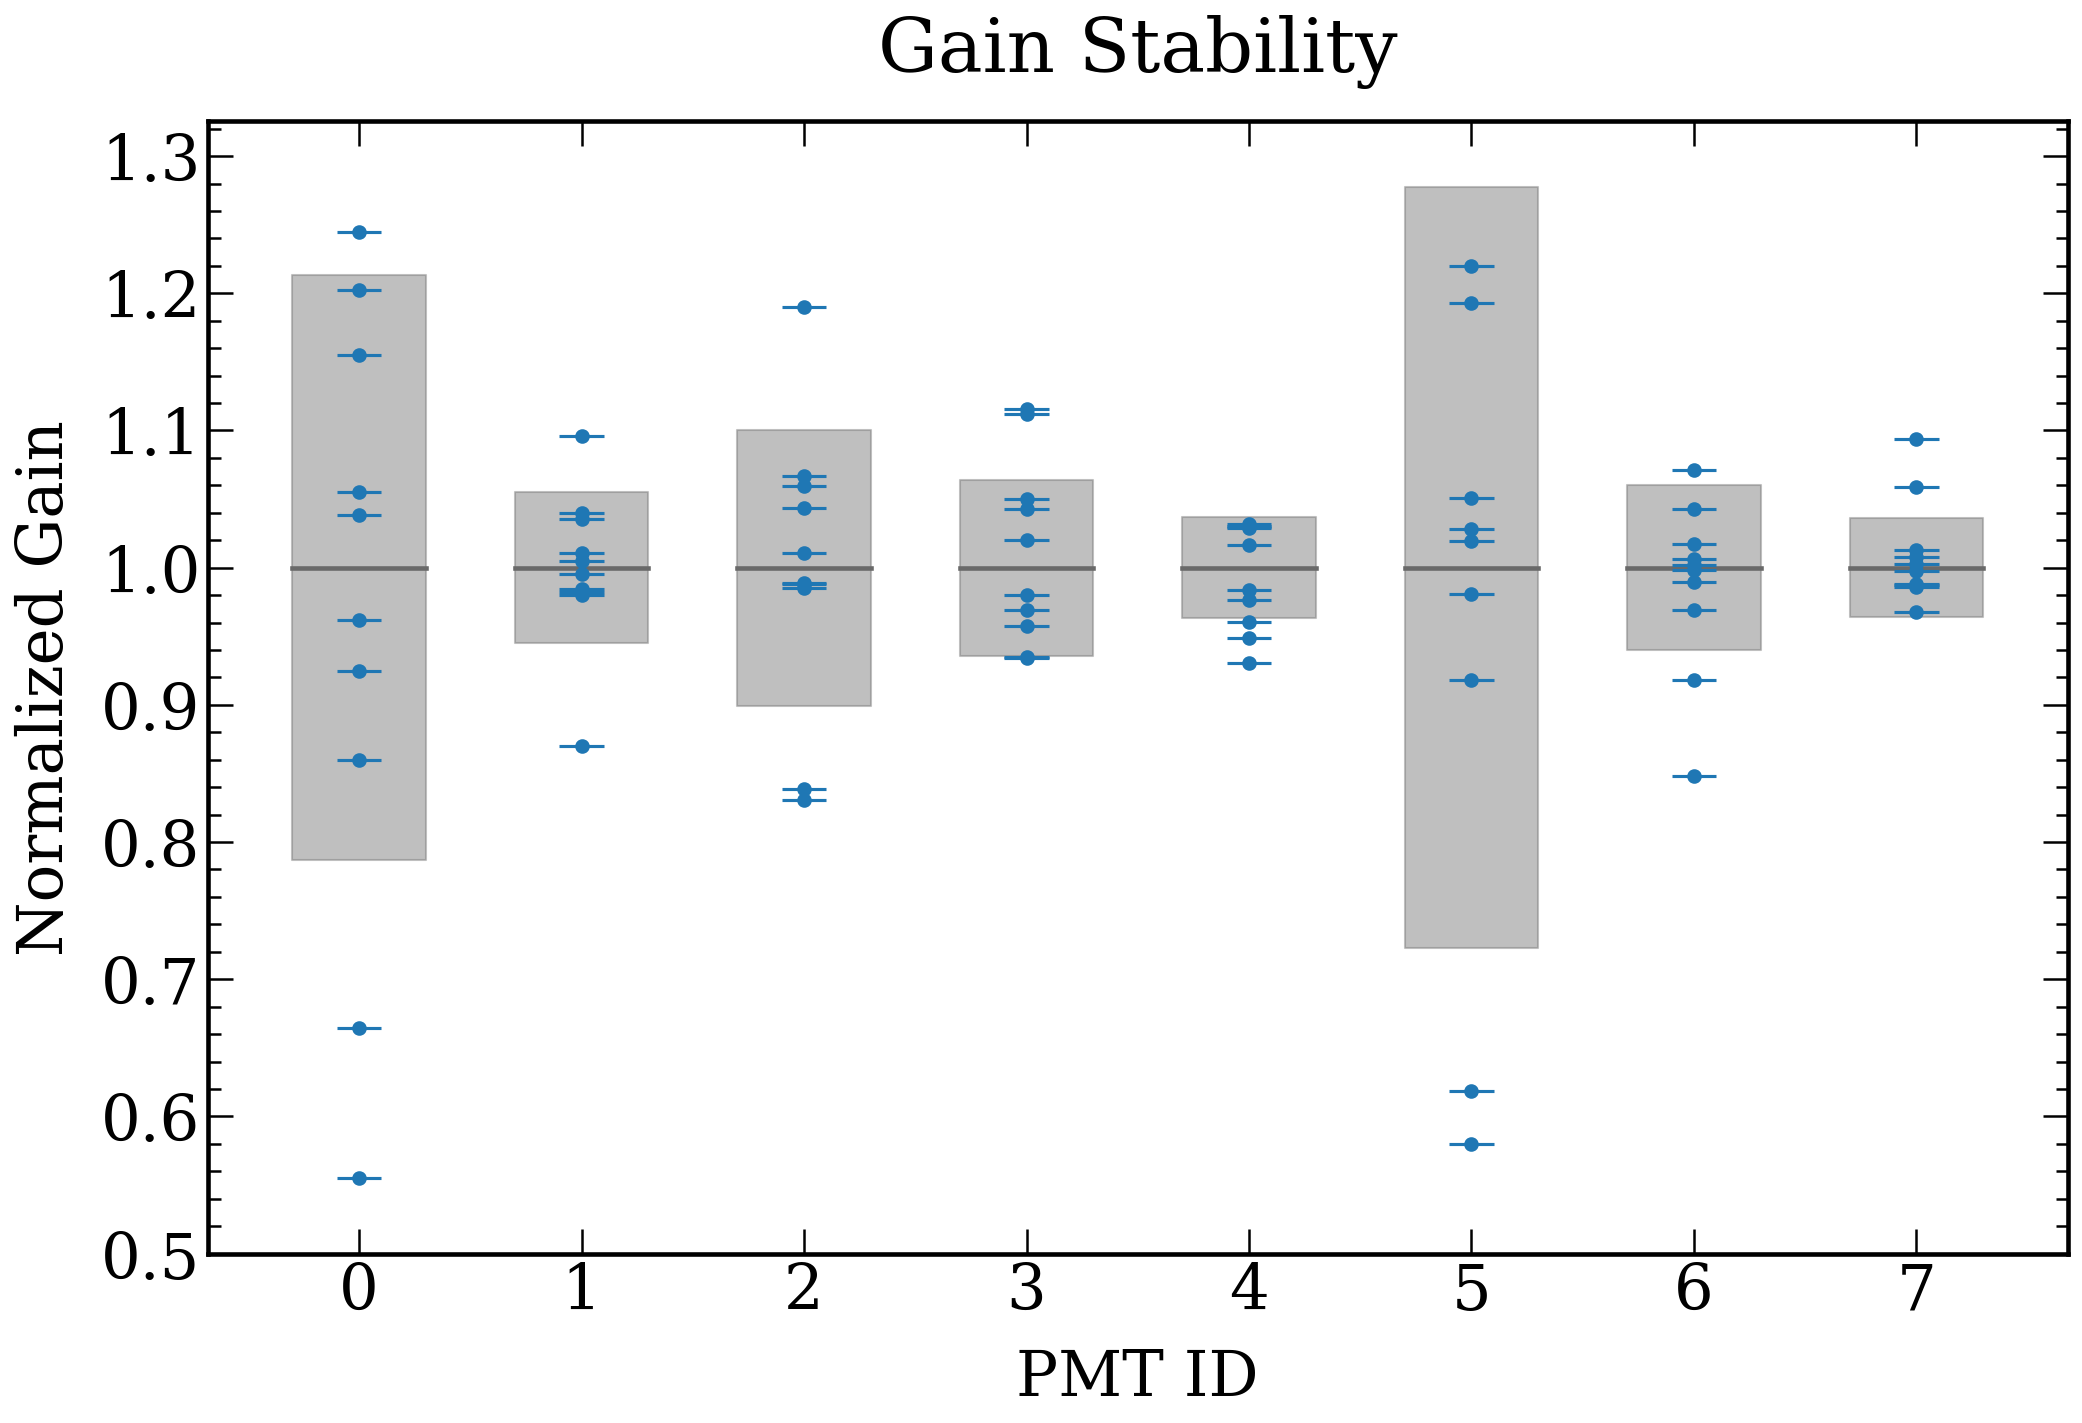

In [21]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
#plt.rc('text', usetex=False)
plt.rc('font', family='serif')

# Labels
label_size = 30 #25
label_pad = 12 #10
title_size = 36 #30
title_pad = 24 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)

# Axes ---> Ticks
axes.xaxis.set_major_locator(MultipleLocator(1))
axes.xaxis.set_minor_locator(NullLocator())
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)

#############################################
## Plot specific settings and plot data
#############################################

# Data plot

for pmt_id in range(0,8):
    
    plt.plot([pmt_id-0.3,pmt_id+0.3],[1,1], color = 'dimgray', linewidth = 2.2)

    gains_unique_normed = gains_unique_list[pmt_id] / np.median(gains_unique_list[pmt_id])
    gains_unique_normed_std = np.std(gains_unique_list[pmt_id]) / np.median(gains_unique_list[pmt_id])

    plt.fill_between([pmt_id-0.3,pmt_id+0.3], 1-gains_unique_normed_std, 1+gains_unique_normed_std, color = 'gray', alpha = 0.5)
    
    plt.errorbar(np.full(len(gains_unique_list[pmt_id]), pmt_id), gains_unique_normed, color = 'C0', zorder = 20, fmt = 'o', xerr = 0.1)

plt.xlabel('PMT ID', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Normalized Gain', fontsize = label_size, labelpad = label_pad)
plt.title('Gain Stability', fontsize = title_size, pad = title_pad)

plt.ylim(bottom = 0.5)

'''# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False, 
                title = 'PMT ID')
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"'''

plt.show()

fig.savefig("Gain Stability_comparison_normalized.png")